# Search for anti_defence_systems

In [3]:
import os
import re
import pandas as pd
import seaborn as sns
from Bio import *
import matplotlib.pyplot as plt
import warnings
import numpy as np
import pandas as pd
from Bio import SeqIO
import traceback
from Bio import Phylo
from ete3 import Tree
import shutil
#from colormap import rgb2hex

In [ ]:
def tblout_to_df(table_filepath, table_name, df_filepath): 
    table_filepath = table_filepath
    table_name = table_name
    df_filepath = df_filepath
    
    with open(str(table_filepath) + '/' +  str(table_name), 'r') as f: 
        line = f.readline()
        with open (str(df_filepath) + '/' +  str(table_name), 'w') as file: 
            file.write('')
        file.close
        while line: 
            line = f.readline()
            if '#' not in line: 
                with open (str(df_filepath) + '/' + str(table_name), 'a') as file: 
                    file.write(line)
            else: 
                pass
        f.close()
    # col_names = ['target_name', 'target_accession', 'query_name', 'query_accession', 'e-value',
    #             'score', 'bias','e-value', 'score', 'bias' 'exp', 'reg', 'clu', 'ov', 'env', 'dom','rep', 'inc', 'query description']
    
    df = read_hmmer(table_filepath + '/' + str(table_filename),program = 'hmmsearch', format = 'tblout', add_header_as_index=False, verbose = True)
    if df.shape != (0,0):
        df.to_csv(df_filepath + '/' + str(table_name) + '.csv', index = False)

In [ ]:
# -*- coding: utf-8 -*-
from __future__ import print_function, division

# Built-ins
import os, sys, time, datetime, uuid, pickle, gzip, bz2, zipfile, requests, operator, warnings, functools
from collections import OrderedDict, defaultdict, Mapping
from io import TextIOWrapper
import xml.etree.ElementTree as ET
import importlib

# Version-specific modules
if sys.version_info.major == 2:
    import pathlib2 as pathlib
    import string
    import bz2file
    setattr(bz2, "open", bz2file.open) # Hack to use open with bz2
else:
    import pathlib

# External
from tqdm import tqdm, tqdm_notebook, tqdm_gui
import pandas as pd
import numpy as np


# =====
# Formatting
# =====
# Remove pairwise nan
def remove_pairwise_nan(a, b, checks=True):
    """
    Remove nan values for a pairwise function
    
    Benchmark:
    data:150 dimensionality pd.Series with 1 nan in a
    checks=True: 177 µs ± 14.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
    checks=False: 111 µs ± 1.91 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
    """
    if checks:
        assert isinstance(a, (np.ndarray, pd.Series))
        assert type(a) is type(b), "`a` and `b` must be the same type"
        assert a.size == b.size, "`a` and `b` must be the same size.  The sizes are {} and {}, respectively".format(a.size, b.size)
        if isinstance(a, pd.Series):
            assert np.all(a.index == b.index), "`a` and `b` must be the same index"
    index = None
    name_a = None
    name_b = None
    if isinstance(a, pd.Series):
        index = a.index
        name_a = a.name
        name_b = b.name
        a = a.values
        b = b.values
    mask_nan = ~np.logical_or(np.isnan(a), np.isnan(b))
    a = a[mask_nan]
    b = b[mask_nan]
    if index is not None:
        a = pd.Series(a, index=index[mask_nan], name=name_a)
        b = pd.Series(b, index=index[mask_nan], name=name_b)
    return (a,b)

# Format pairwise
def format_pairwise(a, b, nans_ok=True, assert_not_empty=True):
    """
    Prepare two pd.Series for a pairwise operation by getting overlapping indices and droping nan
    """
    # Assert a and b are series
    assert isinstance(a, pd.Series)
    assert isinstance(b, pd.Series)
    # Get overlap of index
    index = a.index & b.index
    if assert_not_empty:
        assert index.size > 0, "There are no overlapping elements between a.index and b.index"
    a = a[index]
    b = b[index]
    
    number_of_nans = pd.concat([a.isnull(), b.isnull()]).sum()
    
    if number_of_nans > 0:
        if nans_ok:
            a, b = remove_pairwise_nan(a,b,checks=False)
        else:
            raise ValueError("`nans_ok=False` and there are {} total `nan` between `a` and `b`".format(number_of_nans))
    return a, b

# Format memory
def format_memory(B, unit="infer", return_units=True):
    """
    Return the given bytes as a human readable KB, MB, GB, or TB string
    1 KB = 1024 Bytes
    Adapted from the following source (@whereisalext):
    https://stackoverflow.com/questions/12523586/python-format-size-application-converting-b-to-kb-mb-gb-tb/52379087
    """
    B = float(B)
    KB = float(1024)
    MB = float(KB ** 2) # 1,048,576
    GB = float(KB ** 3) # 1,073,741,824
    TB = float(KB ** 4) # 1,099,511,627,776
    
    # Human readable
    size_in_b = int(B)
    size_in_kb = B/KB
    size_in_mb = B/MB
    size_in_gb = B/GB
    size_in_tb = B/TB
    
    if return_units:
        size_in_b = '{0} B'.format(size_in_b)
        size_in_kb = '{0:.3f} KB'.format(size_in_kb)
        size_in_mb = '{0:.3f} MB'.format(size_in_mb)
        size_in_gb = '{0:.3f} GB'.format(size_in_gb)
        size_in_tb = '{0:.3f} TB'.format(size_in_tb)
    
    unit = unit.lower()
    assert_acceptable_arguments(unit.lower(), {"infer", "b", "kb", "mb", "gb", "tb"})
    if unit != "infer":
        return {"b":size_in_b, "kb":size_in_kb, "mb":size_in_mb, "gb":size_in_gb, "tb":size_in_tb}[unit]
    else:
        if B < KB:
            return size_in_b
        elif KB <= B < MB:
            return size_in_kb
        elif MB <= B < GB:
            return size_in_mb
        elif GB <= B < TB:
            return size_in_gb
        elif TB <= B:
            return size_in_tb


# Get duration
def format_duration(t0):
    """
    Adapted from @john-fouhy:
    https://stackoverflow.com/questions/538666/python-format-timedelta-to-string
    """
    duration = time.time() - t0
    hours, remainder = divmod(duration, 3600)
    minutes, seconds = divmod(remainder, 60)
    return "{:02}:{:02}:{:02}".format(int(hours), int(minutes), int(seconds))


# Format file path
def format_path(path,  into=str, absolute=False):
    assert not is_file_like(path), "`path` cannot be file-like"
    if hasattr(path, "absolute"):
        path = str(path.absolute())
    if hasattr(path, "path"):
        path = str(path.path)
    if absolute:
        path = os.path.abspath(path)
    return into(path)

# Format header for printing
def format_header(text, line_character="=", n=None):
    if n is None:
        n = len(text)
    line = n*line_character
    return "{}\n{}\n{}".format(line, text, line)

# ============
# Dictionaries
# ============
# Dictionary as a tree
def dict_tree():
    """
    Source: https://gist.github.com/hrldcpr/2012250
    """
    return defaultdict(dict_tree)

# Reverse a dictionary
def dict_reverse(d):
    into = type(d)
    data = [(v,k) for k,v in d.items()]
    return into(data)

# Expand dictionary
def dict_expand(d, into=pd.Series, **kwargs):
    """
    Convert {group:[elements]} ==> {element[i]:group[j]}
    """
    return into(OrderedDict((r,p) for p,q in d.items() for r in q), **kwargs)

# Fill dictionary
def dict_fill(d, index, filler_value=np.nan, into=dict):
    data = [(k,filler_value) for k in index if k not in d] + list(d.items())
    return into(data)

# Build a dictionary from repeated elements
def dict_build(input_data, into=dict):
    """
    input_data: [(value, iterable)]
    d_output: {key_in_iterable:value}
    """
    d_output = OrderedDict()
    for value, iterable in input_data:
        for key in iterable:
            d_output[key] = value
    return into(d_output)

# Fold dictionary
def dict_collapse(d, into=dict):
    """
    Folds dictionary into dict of lists
    """
    d_collapsed = defaultdict(list)
    for k,v in d.items():
        d_collapsed[v].append(k)
    return into(d_collapsed)

# Subset a dictionary
def dict_filter(d, keys, into=dict):
    """
    keys can be an iterable or function
    """
    if hasattr(keys, "__call__"):
        f = keys
        keys = filter(f, d.keys())
    return into(map(lambda k:(k,d[k]), keys))

# Convert python dictionary to bash
def dict_py_to_bash(d, bash_obj_name="DICT"):
    """
    Adapted from source:
    * https://stackoverflow.com/questions/1494178/how-to-define-hash-tables-in-bash
    
    Converts a Python dictionary or pd.Series to a bash dictionary.
    """
    bash_placeholder = "declare -A {}=(".format(bash_obj_name)
    for k,v in d.items():
        bash_placeholder += ' ["{}"]="{}"'.format(k,v)
    bash_placeholder += ")"
    return bash_placeholder

# ===========
# Assertions
# ===========
def assert_acceptable_arguments(query, target, operation="le", message="Invalid option provided.  Please refer to the following for acceptable arguments:"):
    """
    le: operator.le(a, b) : <=
    eq: operator.eq(a, b) : ==
    ge: operator.ge(a, b) : >=
    """
    # If query is not a nonstring iterable or a tuple
    if any([
            not is_nonstring_iterable(query),
            isinstance(query,tuple),
            ]):
        query = [query]
    query = set(query)
    target = set(target)
    func_operation = getattr(operator, operation)
    assert func_operation(query,target), "{}\n{}".format(message, target)

# Check packages
def check_packages(packages, namespace=None,  language="python", import_into_backend=False, verbose=False):
    """
    Check if packages are available (and import into global namespace)
    Handles python and R packages via rpy2
    If package is a tuple then imports as follows: ("numpy", "np") where "numpy" is full package name and "np" is abbreviation
    If R packages are being checked, please install rpy2
    To import packages into current namespace: namespace = globals()
    To import packages in backend, e.g. if this is used in a module/script, use `import_into_backend`
    packages: str, non-tuple iterable
    usage:
    @check_packages(["sklearn", "scipy"], language="python")
    def f():
        pass
    @check_packages(["ape"], language="r")
    def f():
        pass
    """
    # Force packages into sorted non-redundant list
    if isinstance(packages,(str, tuple)):
        packages = [packages]
    packages = set(packages)

    # Set up decorator for Python imports
    if language.lower() == "python":
        import_package = importlib.import_module
        importing_error = ImportError
    # Set up decorator for R imports
    if language.lower() == "r":
        try:
            import rpy2
        except ImportError:
            raise Exception("Please install 'rpy2' to import R packages")
        from rpy2.robjects.packages import importr
        from rpy2 import __version__ as rpy2_version
        rpy2_version_major = int(rpy2_version.split(".")[0])
        assert rpy2_version_major > 1, "Please update your rpy2 version"
        if rpy2_version_major == 2:
            from rpy2.rinterface import RRuntimeError
            importing_error = RRuntimeError
        if rpy2_version_major == 3:
            # from rpy2.rinterface_lib.embedded import RRuntimeError
            from rpy2.robjects.packages import PackageNotInstalledError
            importing_error = PackageNotInstalledError
        import_package = importr

    # Wrapper
    def decorator(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            missing_packages = []
            for pkg in packages:
                if isinstance(pkg, tuple):
                    assert len(pkg) == 2, "If a package is tuple type then it must have 2 elements e.g. ('numpy', 'np')"
                    pkg_name, pkg_variable = pkg
                else:
                    pkg_name = pkg_variable = pkg 
                try:
                    package = import_package(pkg_name)
                    if import_into_backend:
                        globals()[pkg_variable] = package
                    if namespace is not None:
                        namespace[pkg_variable] = package
                    if verbose:
                        print("Importing {} as {}".format(pkg_name, pkg_variable), True, file=sys.stderr)
                except importing_error:
                    missing_packages.append(pkg_name)
                    if verbose:
                        print("Cannot import {}:".format(pkg_name), False, file=sys.stderr)
            assert not missing_packages, "Please install the following {} packages to use this function:\n{}".format(language.capitalize(), ", ".join(missing_packages))
            return func(*args, **kwargs)

        return wrapper
    return decorator

# ===========
# Types
# ===========
def is_function(obj):
    return hasattr(obj, "__call__")
def is_file_like(obj):
    return hasattr(obj, "read")
def is_dict(obj):
    return isinstance(obj, Mapping)
def is_nonstring_iterable(obj):
    condition_1 = hasattr(obj, "__iter__")
    condition_2 =  not type(obj) == str
    return all([condition_1,condition_2])
def is_dict_like(obj):
    condition_1 = is_dict(obj)
    condition_2 = isinstance(obj, pd.Series)
    return any([condition_1, condition_2])

def is_all_same_type(iterable):
    iterable_types = set(map(lambda obj:type(obj), iterable))
    return len(iterable_types) == 1

def is_iterable_of(obj, type, assert_iterable=False):
    is_iterable = hasattr(obj, "__iter__")
    if assert_iterable:
        assert is_iterable, "`obj` is not an iterable"
    if is_iterable:
        return all(map(lambda x: isinstance(x,type), obj))
    else:
        return False
        
def is_number(x, num_type = np.number):
    return np.issubdtype(type(x), num_type)
def is_query_class(x,query, case_sensitive=False):
    # Format single search queries
    if type(query) == str:
        query = [query]
    # Remove case if necessary
    x_classname = str(x.__class__)
    if not case_sensitive:
        x_classname = x_classname.lower()
        query = map(lambda q:q.lower(),query)
    # Check if any of the tags in query are in the input class
    verdict = any(q in x_classname for q in query)
    return verdict
def is_path_like(obj, path_must_exist=True):
    condition_1 = type(obj) == str
    condition_2 = hasattr(obj, "absolute")
    condition_3 = hasattr(obj, "path")
    obj_is_path_like = any([condition_1, condition_2, condition_3])
    if path_must_exist:
        if obj_is_path_like:
            return os.path.exists(obj)
        else:
            return False
    else:
        return obj_is_path_like

def is_in_namespace(variable_names, namespace, func_logic=all):
    """
    Check if variable names are in the namespace (i.e. globals())
    """
    assert hasattr(variable_names, "__iter__"), "`variable_names` should be either a single string on an object or an iterable of strings of variable names"
    if isinstance(variable_names, str):
        variable_names = [variable_names]
    namespace = set(namespace)
    return func_logic(map(lambda x: x in namespace, variable_names))

def is_symmetrical(X, tol=None):
    assert len(X.shape) == 2 , "`X` must be 2-dimensional"
    assert X.shape[0] == X.shape[1], "`X` must be square"
    X = X.copy()
    if isinstance(X, pd.DataFrame):
        X = X.values
    np.fill_diagonal(X, 0)
    
    if tol is None:
        return np.all(np.tril(X) == np.triu(X).T)
    if tol:
        return (np.tril(X) - np.triu(X).T).ravel().min() < tol

def is_graph(obj, attr="has_edge"):
    return hasattr(obj, attr)

@check_packages(["matplotlib"])
def is_color(obj):
    from matplotlib.colors import to_rgba
    # Note: This can't handle values that are RGB in (0-255) only (0,1)
    try:
        to_rgba(obj)
        return True
    except ValueError:
        verdict = False
        if is_nonstring_iterable(obj):
            if all(isinstance(c, (float, int)) for c in obj):
                # Check [0,1]
                if all(0 <= c <= 1 for c in obj):
                    verdict = True
#                 # Check [0,255]
#                 if not verdict:
#                     if all(0 <= c <= 255 for c in obj):
#                         verdict = True
        return verdict

@check_packages(["matplotlib"])
def get_color_midpoint(a, b, alpha=1.0, return_type="hex"):
    from matplotlib.colors import to_rgba, to_hex
    assert_acceptable_arguments(return_type, {"rgba", "rgb", "hex"})
    a = to_rgba(a, alpha=alpha)
    b = to_rgba(b, alpha=alpha)
    c = tuple(np.stack([a,b]).mean(axis=0))
    if return_type == "rgba":
        return c
    if return_type == "rgb":
        return c[:-1]
    if return_type == "hex":
        return to_hex(c)
# =======
# Utility
# =======
# Infer compression
def infer_compression(path):
    path = format_path(path)
    compression = None
    ext_zip = (".zip")
    ext_gzip = (".gz", ".gzip", ".pgz")
    ext_bz2 = (".bz2", ".bzip2", ".pbz2")
    if path.endswith(ext_gzip):
        compression= "gzip"
    if path.endswith(ext_bz2):
        compression = "bz2"
    if path.endswith(ext_zip):
        compression = "zip"
    return compression
# Get current timestamp
def get_timestamp(fmt="%Y-%m-%d %H:%M:%S"):
    return datetime.datetime.utcnow().strftime(fmt)
# Wrapper for tqdm
def pv(iterable, description=None, version=None, total=None, unit='it'):
    """
    Progress viewer
    Wrapper for `tqdm`:
    https://github.com/tqdm/tqdm
    """
    assert_acceptable_arguments([version], {None, "gui",  "notebook"})
    func = tqdm
    if version == "notebook":
        func = tqdm_notebook
    if version == "gui":
        func = tqdm_gui

    return tqdm(
        iterable,
        desc=description,
        total=total,
        unit=unit,
   )

# Creates a unique identifier
def get_unique_identifier():
    return uuid.uuid4().hex


def contains(query, include, exclude=None):
    """
    Is anything from `include` in `query` that doesn't include anything from `exclude`
    `query` can be any iterator that is not a generator
    """
    if isinstance(include, str):
        include = [include]
    condition_A = any(x in query for x in include)
    if exclude is not None:
        if type(exclude) == str:
            exclude = [exclude]
        condition_B = all(x not in query for x in exclude)
        return all([condition_A, condition_B])
    else:
        return condition_A
# Consecutive replace on a string
def consecutive_replace(x, *patterns):
    if len(patterns) == 1:
        patterns = patterns[0]
    for (a,b) in patterns:
        x = x.replace(a,b)
    return x

# Boolean
def boolean(x, true_values={"true", "t", "yes", "1"}, false_values={"false", "f", "no", "0"}, assertion_message="Please choose either: 'True' or 'False'"):
    """
    Not case sensitive
    """
    x = str(x).lower()
    option = None
    if x in list(map(str,true_values)):
        option = True
    if x in list(map(str,false_values)):
        option = False
    assert option is not None, assertion_message
    return option

# Truncate a float by a certain precision
def to_precision(x, precision=5, into=float):
    return into(("{0:.%ie}" % (precision-1)).format(x))


# Left padding
def pad_left(x, block_size=3, fill=0):
    """
    Pad a string representation of digits
    """
    if len(x) > block_size:
        return x
    else:
        right = np.array(list(str(x)))
        left = np.repeat(str(fill), block_size - right.size )
        return "".join(np.concatenate([left, right]))
# Join as strings
def join_as_strings(delimiter="_", *args):
    return delimiter.join(list(map(str, args)))

# =============
# Iterables
# =============
# Fragment a sequence string
def fragment(seq, K=5, step=1, overlap=False):
    K = int(K)
    step = int(step)
    if not overlap:
        step = K
    iterable = range(0, len(seq) - K + 1, step)
    for i in iterable:
        frag = seq[i:i+K]
        yield frag

# Get depth of an iterable
def iterable_depth(arg, exclude=None):
    # Adapted from the following SO post:
    # https://stackoverflow.com/questions/6039103/counting-depth-or-the-deepest-level-a-nested-list-goes-to
    # @marco-sulla
    exclude = set([str])
    if exclude is not None:
        if not hasattr(exclude, "__iter__"):
            exclude = [exclude]
        exclude.update(exclude)

    if isinstance(arg, tuple(exclude)):
        return 0

    try:
        if next(iter(arg)) is arg:  # avoid infinite loops
            return 1
    except TypeError:
        return 0

    try:
        depths_in = map(lambda x: iterable_depth(x, exclude), arg.values())
    except AttributeError:
        try:
            depths_in = map(lambda x: iterable_depth(x, exclude), arg)
        except TypeError:
            return 0
    try:
        depth_in = max(depths_in)
    except ValueError:
        depth_in = 0

    return 1 + depth_in

# Flatten nested iterables
def flatten(nested_iterable, into=list, unique=False, **kwargs_iterable):
    # Adapted from @wim:
    # https://stackoverflow.com/questions/16312257/flatten-an-iterable-of-iterables
    def _func_recursive(nested_iterable):
        for x in nested_iterable:
            if is_nonstring_iterable(x):
                for element in flatten(x):
                    yield element
            else:
                yield x
    # Unpack data
    data_flattened = list(_func_recursive(nested_iterable))
    if unique:
        data_flattened = sorted(set(data_flattened))
    # Convert type
    return into(data_flattened, **kwargs_iterable)

# Range like input data
def range_like(data, start=0):
    return np.arange(len(data)) + start

# Set Intersection
def intersection(*iterables, **kwargs):
    sets = map(set, iterables)
    if "into" in kwargs: # Py2/3 Compatability
        into = kwargs.pop("into")
    else:
        into = set
    return into(set.intersection(*sets), **kwargs)

# Set Union
def union(*iterables, **kwargs):
    sets = map(set, iterables)
    if "into" in kwargs: # Py2/3 Compatability
        into = kwargs.pop("into")
    else:
        into = set
    return into(set.union(*sets), **kwargs)
# =========
# I/O
# =========
def read_column(path=None, into=list, linebreak="\n", lstrip=True, rstrip=True, compression="infer", sheet_name=0, astype=str, exclude=("nan")):
    """
    If path is None, column is read from clipboard
    If path endswith .xls or .xlsx, 1st column from 1st sheet is read from excel doc
    All else, column is read from filepath contents
    """
    if path is None:
        from pandas.io.clipboard import clipboard_get
        text = clipboard_get()
    else:
        if path.endswith((".xls", "xlsx")):
            text = linebreak.join(map(str, read_dataframe(path, sheet_name=sheet_name).index))
        else:
            with get_file_object(path, mode="read", compression=compression, safe_mode=False, verbose=False) as f:
                text = f.read()
    
    elements = list()
    for element in text.split(linebreak):
        if lstrip:
            if isinstance(lstrip, str):
                element = element.lstrip(lstrip)
            else:
                element = element.lstrip()
        if rstrip:
            if isinstance(rstrip, str):
                element = element.rstrip(rstrip)
            else:
                element = element.rstrip()
        if bool(element):
            if element not in exclude:
                element = astype(element)
                elements.append(element)
    return into(elements)

def read_from_clipboard(sep="\n", into=list):
    from pandas.io.clipboard import clipboard_get
    text = clipboard_get()
    if sep is not None:
        return into(filter(bool, map(lambda x:x.strip(), text.split(sep))))
    else:
        return text

# Read dataframe
def read_dataframe(path, sep="infer", index_col=0, header=0, compression="infer", pickled="infer", func_index=None, func_columns=None, evaluate_columns=None, engine="c", verbose=False, excel="infer", infer_series=False, sheet_name=None,  **kwargs):
    start_time= time.time()
    path = format_path(path, str)
    dir , ext = os.path.splitext(path)
    ext = ext.lower()

    if excel == "infer":
        if ext in {".xlsx", ".xls"}:
            excel = True
        else:
            excel = False

    if excel:
        if "sheetname" in kwargs:
            sheet_name = kwargs.pop("sheetname")
            warnings.warn("Use `sheet_name` instead of `sheetname`", warnings.DeprecationWarning)

        df = pd.read_excel(path, sheet_name=sheet_name, index_col=index_col, header=header, **kwargs)

    else:
        # Seperator
        if any(list(map(lambda x:ext.endswith(x),[".csv", "csv.gz", "csv.zip"]))):
            sep = ","
        else:
            sep = "\t"

        # Serialization
        if pickled == "infer":
            if ext in {".pkl", ".pgz", ".pbz2"}:
                pickled = True
            else:
                pickled = False
        # Compression
        if compression == "infer":
            if pickled:
                if ext == ".pkl":
                    compression = None
                if ext == ".pgz":
                    compression = "gzip"
                if ext == ".pbz2":
                    compression = "bz2"
            else:
                if ext == ".gz":
                    compression = "gzip"
                if ext == ".bz2":
                    compression = "bz2"
                if ext == ".zip":
                    compression = "zip"


        if pickled:
            df = pd.read_pickle(path, compression=compression, **kwargs)
        else:
            df = pd.read_csv(path, sep=sep, index_col=index_col, header=header, compression=compression, engine=engine, **kwargs)

    condition_A = any([(excel == False), (sheet_name is not None)])
    condition_B = all([(excel == True), (sheet_name is None)])

    if condition_A:
        # Map indices
        if func_index is not None:
            df.index = df.index.map(func_index)
        if func_columns is not None:
            df.columns = df.columns.map(func_columns)

        if evaluate_columns is not None:
            for field_column in evaluate_columns:
                try:
                    df[field_column] = df[field_column].map(eval)
                except ValueError:
                    if verbose:
                        print("Could not use `eval` on column=`{}`".format(field_column), file=sys.stderr)
        if verbose:
            print("{} | Dimensions: {} | Time: {}".format(
                path.split('/')[-1],
                df.shape,
                format_duration(start_time),
                ), file=sys.stderr)
    if condition_B:
        if verbose:
            print("{} | Sheets: {} | Time: {}".format(
            path.split('/')[-1],
            len(df),
            format_duration(start_time),
            ), file=sys.stderr)
    if infer_series:
        if df.shape[1] == 1:
            df = df.iloc[:,0]
    return df

# Write dataframe
def write_dataframe(data, path, sep="\t", compression="infer", pickled="infer",  excel="infer",  **kwargs):
    start_time = time.time()
    path = format_path(path, str)
    _ , ext = os.path.splitext(path)
    dir, filename = os.path.split(path)

    # Excel
    if excel == "infer":
        if ext in {".xlsx", ".xls"}:
            excel = True
        else:
            excel = False

    if excel:
        if not is_dict(data):
            data = {"Sheet1":data}
        writer = pd.ExcelWriter(path)
        for sheet_name, df in data.items():
            df.to_excel(writer, sheet_name=str(sheet_name), **kwargs)
        writer.save()
    else:
        # Serialization
        if pickled == "infer":
            if ext in {".pkl", ".pgz", ".pbz2"}:
                pickled = True
            else:
                pickled = False
        # Compression
        if compression == "infer":
            if pickled:
                if ext == ".pkl":
                    compression = None
                if ext == ".pgz":
                    compression = "gzip"
                if ext == ".pbz2":
                    compression = "bz2"
            else:
                compression = None
                if ext == ".gz":
                    compression = "gzip"
                if ext == ".bz2":
                    compression = "bz2"

        if pickled:
            data.to_pickle(path, compression=compression, **kwargs)
        else:
            data.to_csv(path, sep=sep, compression=compression, **kwargs)

# Create file object
def get_file_object(path, mode="infer", compression="infer", safe_mode="infer", verbose=True):
    """
    with get_file_object("./test.txt.zip", mode="infer", verbose=False) as f_read:
    with get_file_object("./test_write.txt.bz2", mode="write", verbose=False) as f_write:
        for line in f_read.readlines():
            line = str(line.strip())
            print(line, file=f_write)
    """
    # Init
    f = None
    file_will_be_written = False

    # Paths
    path = format_path(path)
    path_exists = os.path.exists(path)


    if compression == "infer":
        compression = infer_compression(path)
        if verbose:
            print("Inferring compression:", compression, file=sys.stderr)

    # Inferring mode
    if mode == "infer": # Create new function for this? infer_filemode?
        if path_exists:
            mode = "read"
        else:
            mode = "write"
    assert mode != "infer", "The mode should be inferred by this point.  Please specify mode manually."
    assert compression != "infer", "The compression should be inferred by this point.  Please specify compression manually."

    # Generic read write
    if mode in ["write", "read"]:
        if mode == "write":
            mode = "w"
        if mode == "read":
            mode = "r"
        if compression in ["gzip", "bz2"]:
            mode = mode + "b"
        if verbose:
            print("Inferring mode:", mode, file=sys.stderr)

    if verbose:
        if mode == "r":
            print("Reading file:",path, file=sys.stderr)

        if mode == "w":
            print("Writing file:",path, file=sys.stderr)

    # Will a file be written?
    if "w" in mode:
        file_will_be_written = True

    # Ensure zip is not being written
    if file_will_be_written:
        assert compression != "zip", "Currently cannot handle writing zip files.  Please use gzip, bz2, or None."
        # Future do this:
        # https://docs.python.org/3/library/zipfile.html#zipfile.ZipFile.open

    # Safe mode
    if safe_mode == "infer":
        if file_will_be_written:
            safe_mode = True
        else:
            safe_mode = False
    assert safe_mode in {True,False}, "Please choose either True or False for `safe_mode`"
    if safe_mode:
        if all([file_will_be_written, path_exists]):
            raise Exception("Safe Mode: Please explicitly provide a writeable mode ['w', 'wb', or 'write'] because `{}` already exists and will be rewritten.".format(path))

    # GZIP compression
    if compression == "gzip":
        f = gzip.open(path, mode)
        f.read1 = f.read # Hack from https://github.com/kislyuk/eight/issues/1
    # BZ2 compression
    if compression == "bz2":
        f = bz2.open(path, mode)
    if compression == "zip":
        filename, ext = os.path.splitext(os.path.split(path)[-1])
        f = zipfile.ZipFile(path,mode).open(filename)
    # No compression
    if f is None:
        return open(path, mode)

    # Reading and writing compressed files
    else:
        return TextIOWrapper(f, encoding="utf-8")


# Text reading wrapper
def read_textfile(path, enum=False, generator=True, mode="read", compression="infer", into=pd.Series):
    """
    2018-May-29
    Edits: 2018-December-27: Added `get_file_object` dependency
    """
    assert mode not in ["w", "wb", "a"], "`mode` should not be in {w, wb, a} because it will overwrite"
    assert compression  in ["infer", "gzip", "bz2", "zip", None], "Valid `compression` types are 'infer', 'gzip', 'bz2', 'zip'"
    # Format file path
    path = format_path(path, str)
    # Get file object
    handle = get_file_object(path=path, mode=mode, compression=compression, safe_mode=False, verbose=False)
    # Nested functions
    def run_return_list(handle):
        data = handle.read().split("\n")
        handle.close()
        if into == pd.Series:
            return pd.Series(data, name=path)
        else:
            if enum:
                return into(list(enumerate(data)))
            if not enum:
                return into(data)

    def run_return_iterable(handle):
        if enum:
            for i,line in enumerate(handle):
                yield i, line.strip()
        if not enum:
            for line in handle:
                yield line.strip()
        handle.close()

    # Controller
    if generator:
        return run_return_iterable(handle=handle)
    if not generator:
        return run_return_list(handle=handle)

# Reading serial object
def read_object(path, compression="infer", serialization_module=pickle):
    path = format_path(path, str)

    if compression == "infer":
        _ , ext = os.path.splitext(path)
        if (ext == ".pkl") or (ext == ".dill"):
            compression = None
        if ext in {".pgz", ".gz"}:
            compression = "gzip"
        if ext in {".pbz2", ".bz2"}:
            compression = "bz2"
    if compression is not None:
        if compression == "gzip":
            f = gzip.open(path, "rb")
        if compression == "bz2":
            f = bz2.open(path, "rb")
    else:
        f = open(path, "rb")
    obj = serialization_module.load(f)
    f.close()
    return obj

# Writing serial object
def write_object(obj, path, compression="infer", serialization_module=pickle, protocol=None, *args):
    """
    Extensions:
    pickle ==> .pkl
    dill ==> .dill
    gzipped-pickle ==> .pgz
    bzip2-pickle ==> .pbz2
    """
    assert obj is not None, "Warning: `obj` is NoneType"
    path = format_path(path, str)

    # Use infer_compression here
    if compression == "infer":
        _ , ext = os.path.splitext(path)
        if ext in {".pkl", ".dill"}: # if ext in (ext == ".pkl") or (ext == ".dill"):
            compression = None
        if ext in {".pgz", ".gz"}:
            compression = "gzip"
        if ext in {".pbz2", ".bz2"}:
            compression = "bz2"
    if compression is not None:
        if compression == "bz2":
            f = bz2.BZ2File(path, "wb")
        if compression == "gzip":
            f = gzip.GzipFile(path, "wb")
    else:
        f = open(path, "wb")
    serialization_module.dump(obj, f, protocol=protocol, *args)
    f.close()

# Reading html from website
def read_url(url, params=None, **kwargs):
    """
    Future:
    Make wrapper for dynamic html and phantom js
    """
    dynamic = False
    if not dynamic:
        r = requests.get(url, params=params, **kwargs)
        return r.text
    else:
        print("Unavailable: Need to make wrapper for dynamic HTML using PhantomJS", file=sys.stderr)

# Importing a functions from a module
def read_script_as_module(name_module, path):
    # https://stackoverflow.com/questions/67631/how-to-import-a-module-given-the-full-path
    path = format_path(path, str)
    if sys.version_info.major == 2:
         module = imp.load_source(name_module, path)
    else:
        spec = importlib.util.spec_from_file_location(name_module, path)
        module = importlib.util.module_from_spec(spec)
        spec.loader.exec_module(module)
    return module

# Read Fasta File
@check_packages(["Bio"], import_into_backend=False)
def read_fasta(path, description=True, case=None, func_header=None, into=pd.Series, compression="infer", name=None, verbose=False):
    """
    Reads in a single fasta file or a directory of fasta files into a dictionary.
    """
    from Bio.SeqIO.FastaIO import SimpleFastaParser
    # Get path
    path = format_path(path)

    # Assign pathname as name if there isn't one
    if name is None:
        name = path

    # Open file object
    f = get_file_object(path, mode="read", compression=compression, safe_mode=False, verbose=False)

    # Read in fasta
    d_id_seq = OrderedDict()

    if verbose:
        seq_records = pv(SimpleFastaParser(f), "Reading sequence file: {}".format(path))
    else:
        seq_records = SimpleFastaParser(f)

    # Verbose but faster

    if description:
        if case == "lower":
            for header, seq in seq_records:
                seq = seq.lower()
                d_id_seq[header] = seq
        if case == "upper":
            for header, seq in seq_records:
                seq = seq.upper()
                d_id_seq[header] = seq
        if case is None:
            for header, seq in seq_records:
                d_id_seq[header] = seq
    if not description:
        if case == "lower":
            for header, seq in seq_records:
                seq = seq.lower()
                header = header.split(" ")[0]
                d_id_seq[header] = seq
        if case == "upper":
            for header, seq in seq_records:
                seq = seq.upper()
                header = header.split(" ")[0]
                d_id_seq[header] = seq
        if case is None:
            for header, seq in seq_records:
                header = header.split(" ")[0]
                d_id_seq[header] = seq

    # Close File
    f.close()

    # Transform header
    if func_header is not None:
        d_id_seq = OrderedDict( [(func_header(id),seq) for id, seq in d_id_seq.items()])
    sequences = into(d_id_seq)
    if hasattr(sequences, "name"):
        sequences.name = name
    return sequences


# Writing sequence files
def write_fasta(sequences, path, compression="infer"):
    """
    Sequence stats:
    count    29999.000000
    mean       310.621754
    std       1339.422833
    min         56.000000
    25%         75.000000
    50%        111.000000
    75%        219.000000
    max      54446.000000
    Benchmarks:
    No compression: 47.2 ms ± 616 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
    Gzip: 9.85 s ± 261 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    Bzip2: 864 ms ± 16.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    """
    # path = format_path(path)
    # if compression == "infer":
    #     compression = infer_compression(path)
    if is_query_class(path, ["stdout", "stderr", "streamwrapper"]):
        path.writelines(">{}\n{}\n".format(id, seq) for id, seq in sequences.items())
    else:
        with get_file_object(path, mode="write", compression=compression, safe_mode=False, verbose=False) as f:
            f.writelines(">{}\n{}\n".format(id, seq) for id, seq in sequences.items())

# Read blast output
def read_blast(path, length_query=None, length_subject=None, sort_by="bitscore"):
    """
    if 12: ["qseqid" , "sseqid",  "pident",  "length",  "mismatch",  "gapopen",  "qstart",  "qend",  "sstart",  "send", "evalue",  "bitscore",  "qcovs",  "slen", "qlen"]
    if 15 assumes: -outfmt '6 std qlen slen stitle': ["std", "qlen", "slen", "stitle"]
    ####################################################
    Column    NCBI name    Description
    1    qseqid    Query Seq-id (ID of your sequence)
    2    sseqid    Subject Seq-id (ID of the database hit)
    3    pident    Percentage of identical matches
    4    length    Alignment length
    5    mismatch    Number of mismatches
    6    gapopen    Number of gap openings
    7    qstart    Start of alignment in query
    8    qend    End of alignment in query
    9    sstart    Start of alignment in subject (database hit)
    10    send    End of alignment in subject (database hit)
    11    evalue    Expectation value (E-value)
    12    bitscore    Bit score
    13    sallseqid    All subject Seq-id(s), separated by a ';'
    14    score    Raw score
    15    nident    Number of identical matches
    16    positive    Number of positive-scoring matches
    17    gaps    Total number of gaps
    18    ppos    Percentage of positive-scoring matches
    19    qframe    Query frame
    20    sframe    Subject frame
    21    qseq    Aligned part of query sequence
    22    sseq    Aligned part of subject sequence
    23    qlen    Query sequence length
    24    slen    Subject sequence length
    25    salltitles    All subject title(s), separated by a '<>'
    Example inputs:
        * blat -prot Yeast/Saccharomyces_cerevisiae.R64-1-1.pep.all.processed.fa  Phaeodactylum_tricornutum.ASM15095v2.pep.all.processed.fa -out=blast8 yeast-pt.blast8
        * diamond blastp -d ../../../../reference_data/references/gracilibacteria/reference_proteins.nmnd -q ./prodigal_output/orfs.faa -f 6 -o ./diamond_output/output.blast6
    """
    path = format_path(path)
    idx_default_fields = ["qseqid" , "sseqid",  "pident",  "length",  "mismatch",  "gapopen",  "qstart",  "qend",  "sstart",  "send", "evalue",  "bitscore",  "qcovs",  "slen", "qlen"]
    # ["query_id", "subject_id", "identity", "alignment_length", "mismatches", "gap_openings", "query_start", "query_end", "subject_start", "subject_end", "e-value", "bit_score"]
    df_blast = pd.read_csv(path, header=None, sep="\t")
    if df_blast.shape[1] == 12:
        df_blast.columns = idx_default_fields
    if df_blast.shape[1] == 15:
        df_blast.columns = idx_default_fields + ["qlen", "slen", "stitle"]
    # Length of query
    if length_query is not None:
        if is_path_like(length_query):
            length_query = read_fasta(length_query, description=False, verbose=False)
        if isinstance(length_query[0], str):
            length_query = length_query.map(len)
        df_blast["qlength"] = df_blast["qseqid"].map(lambda id: length_query[id])
        df_blast["qratio"] = (df_blast["qend"] - df_blast["qstart"])/df_blast["qlength"]
    # Length of subject
    if length_subject is not None:
        if is_path_like(length_subject):
            length_subject = read_fasta(length_subject, description=False, verbose=False)
        if isinstance(length_subject[0], str):
            length_subject = length_subject.map(len)
        df_blast["slength"] = df_blast["sseqid"].map(lambda id: length_subject[id])
        df_blast["sratio"] = (df_blast["send"] - df_blast["sstart"])/df_blast["slength"]
    if sort_by is not None:
        df_blast = df_blast.sort_values(by=sort_by, ascending=False).reset_index(drop=True)

    return df_blast
# Helper function for reading gtf and gff3
def read_gtf_gff_base(path, compression, record_type, verbose):
    # Read the gff3 file
    with get_file_object(path, mode="read", compression=compression, safe_mode=False, verbose=False) as f:
        if verbose:
            iterable_lines = pv(f.readlines(), "Processing lines")
        else:
            iterable_lines = f.readlines()
        data= list()
        if record_type is None:
            for line in iterable_lines:
                if not line.startswith("#"):
                    line = line.strip("\n")
                    if bool(line):
                        base_fields = line.split("\t")
                        data.append(base_fields)
        else:
            for line in iterable_lines:
                if not line.startswith("#"):
                    if "{}_id".format(record_type) in line:
                        line = line.strip("\n")
                        base_fields = line.split("\t")
                        data.append(base_fields)
    # Generate table
    df_base = pd.DataFrame(data)
    df_base.columns = ["seq_record", "source", "seq_type", "pos_start", "pos_end", ".1", "sense", ".2", "data_fields"]
    return df_base

def read_gff3(path, compression="infer", record_type=None, verbose = True, reset_index=False, name=True):
    def f(x):
        fields = x.split(";")
        data = dict()
        for item in fields:
            k, v = item.split("=")
            data[k] = v
        return data
    path = format_path(path)
    if verbose:
        print("Reading gff3 file:",path,sep="\t", file=sys.stderr)
    accepted_recordtypes = {"exon", "gene", "transcript", "protein", None}
    assert record_type in accepted_recordtypes, "Unrecognized record_type.  Please choose from the following: {}".format(accepted_recordtypes)

    # Read the gff3 file
    df_base = read_gtf_gff_base(path, compression, record_type, verbose)

    try:
        df_fields = pd.DataFrame(df_base["data_fields"].map(f).to_dict()).T
        df_gff3 = pd.concat([df_base[["seq_record", "source", "seq_type", "pos_start", "pos_end", ".1", "sense", ".2"]], df_fields], axis=1)
         # Contains identifier
        if "ID" in df_gff3.columns:
            df_gff3["seq_id"] = df_gff3["ID"].map(lambda x: "-".join(x.split("-")[1:]) if not pd.isnull(x) else x)
        if reset_index:
            df_gff3 = df_gff3.reset_index(drop=True)
    except IndexError:
        warnings.warn("Could not successfully parse file: {}".format(path))
        df_gff3 = df_base

    # Path index
    if name is not None:
        if name == True:
            name = path
        df_gff3.index.name = name

    return df_gff3

# GTF
def read_gtf(path, compression="infer", record_type=None, verbose = True, reset_index=False, name=True):
    path = format_path(path)
    if verbose:
        print("Reading gtf file:",path,sep="\t", file=sys.stderr)
    accepted_recordtypes = {"exon", "gene", "transcript", "protein", None}
    assert record_type in accepted_recordtypes, "Unrecognized record_type.  Please choose from the following: {}".format(accepted_recordtypes)

    # Read the gtf file
    df_base = read_gtf_gff_base(path, compression, record_type, verbose)

    # Splitting fields
    iterable_fields =  df_base.iloc[:,-1].iteritems()

    # Parse fields
    dataframe_build = dict()
    for i, gtf_data in iterable_fields:
        gtf_data = gtf_data.replace("''","").replace('"',"")
        fields = filter(bool, map(lambda field:field.strip(), gtf_data.split(";")))
        fields = map(lambda field: field.split(" "), fields)
        dataframe_build[i] = dict(fields)
    df_fields = pd.DataFrame(dataframe_build).T
    df_gtf = pd.concat([df_base.iloc[:,:7], df_fields], axis=1)

    # Reset index
    if reset_index:
        df_gtf = df_gtf.reset_index(drop=True)

    # Path index
    if name is not None:
        if name == True:
            name = path
        df_gtf.index.name = name
    return df_gtf

# NCBI XML
def read_ncbi_xml(path, index_name=None):
    # Format path
    path = format_path(path)
    # Parse the XML tree
    tree = ET.parse(path)
    root = tree.getroot()
    # Extract the attributes
    data = defaultdict(dict)
    for record in pv(root.getchildren(), "Reading NCBI XML: {}".format(path)):
        id_record = record.attrib["accession"]
        for attribute in record.findall("Attributes/*"):
            data[id_record][attribute.attrib["attribute_name"]] = attribute.text
    # Create pd.DataFrame
    df = pd.DataFrame(data).T
    df.index.name = index_name
    return df

# Read EMBL-EBI sample metadata
def read_ebi_sample_metadata(query, base_url="https://www.ebi.ac.uk/metagenomics/api/v1/samples/{}/metadata", mode="infer"):
    """
    query:
        id_sample: "ERS488919"
        url: "https://www.ebi.ac.uk/metagenomics/api/v1/samples/ERS488919/metadata
        file: "/path/to/ERS488919.json"
    JSON file can be retrieved via:
        curl -X GET "https://www.ebi.ac.uk/metagenomics/api/v1/samples/ERS488919/metadata" -H "accept: application/json" > ERS488919.json
    """
    # Acceptable arguments for mode
    assert_acceptable_arguments(mode, {"infer", "cloud", "local"})

    # Functions
    def _get_url(query, base_url):
        # Is a URL provided?
        if any(map(lambda x: x in query, ["http", "www"])):
            url = query
        # Is a sample identifier provided
        else:
            url = base_url.format(query)
        return url

    # Infer mode
    url = None
    response = None
    if mode == "infer":
        try:
            url = _get_url(query, base_url)
            response = requests.get(url)
            mode = "cloud"
        except requests.exceptions.MissingSchema:
            mode = "local"

    # Cloud
    if mode == "cloud":
        if response is None:
            # Get cloud data
            url = _get_url(query, base_url)
            response = requests.get(url)
        data = response.json()["data"]
    if mode == "local":
        with open(query, "r") as f:
            data = json.loads(f.read())["data"]
    # Determine sample identifier
    id_sample = data[0]["relationships"]["sample"]["data"]["id"]

    return pd.Series(
            data=dict(map(lambda item: (item["attributes"]["key"], item["attributes"]["value"]), data)),
            name=id_sample,
    )

# Read HMMER
def read_hmmer(path, program="hmmsearch", format="tblout", add_header_as_index=False, verbose=True):
    """
    Developed using HMMER v3.2.1
    # =========
    # tblout
    # =========
    (1) target name: The name of the target sequence or profile.
    (2) accession: The accession of the target sequence or profile, or ’-’ if none.
    (3) query name: The name of the query sequence or profile.
    (4) accession: The accession of the query sequence or profile, or ’-’ if none.
    (5) E-value (full sequence): The expectation value (statistical significance) of the target. This is a per
    query E-value; i.e. calculated as the expected number of false positives achieving this comparison’s
    score for a single query against the Z sequences in the target dataset. If you search with multiple
    queries and if you want to control the overall false positive rate of that search rather than the false
    positive rate per query, you will want to multiply this per-query E-value by how many queries you’re
    doing.
    (6) score (full sequence): The score (in bits) for this target/query comparison. It includes the biasedcomposition correction (the “null2” model).
    (7) Bias (full sequence): The biased-composition correction: the bit score difference contributed by
    the null2 model. High bias scores may be a red flag for a false positive, especially when the bias score
    is as large or larger than the overall bit score. It is difficult to correct for all possible ways in which a
    nonrandom but nonhomologous biological sequences can appear to be similar, such as short-period
    tandem repeats, so there are cases where the bias correction is not strong enough (creating false
    positives).
    (8) E-value (best 1 domain): The E-value if only the single best-scoring domain envelope were found
    in the sequence, and none of the others. If this E-value isn’t good, but the full sequence E-value
    is good, this is a potential red flag. Weak hits, none of which are good enough on their own, are
    summing up to lift the sequence up to a high score. Whether this is Good or Bad is not clear; the
    sequence may contain several weak homologous domains, or it might contain a repetitive sequence
    that is hitting by chance (i.e. once one repeat hits, all the repeats hit).
    (9) score (best 1 domain): The bit score if only the single best-scoring domain envelope were found
    in the sequence, and none of the others. (Inclusive of the null2 bias correction.]
    (10) bias (best 1 domain): The null2 bias correction that was applied to the bit score of the single
    best-scoring domain.
    (11) exp: Expected number of domains, as calculated by posterior decoding on the mean number of
    begin states used in the alignment ensemble.
    1The tblout format is deliberately space-delimited (rather than tab-delimited) and justified into aligned columns, so these files
    are suitable both for automated parsing and for human examination. Tab-delimited data files are difficult for humans to examine and
    spot check. For this reason, we think tab-delimited files are a minor evil in the world. Although we occasionally receive shrieks of
    outrage about this, we stubbornly feel that space-delimited files are just as trivial to parse as tab-delimited files.
    (12) reg: Number of discrete regions defined, as calculated by heuristics applied to posterior decoding
    of begin/end state positions in the alignment ensemble. The number of regions will generally be close
    to the expected number of domains. The more different the two numbers are, the less discrete the
    regions appear to be, in terms of probability mass. This usually means one of two things. On the one
    hand, weak homologous domains may be difficult for the heuristics to identify clearly. On the other
    hand, repetitive sequence may appear to have a high expected domain number (from lots of crappy
    possible alignments in the ensemble, no one of which is very convincing on its own, so no one region
    is discretely well-defined).
    (13) clu: Number of regions that appeared to be multidomain, and therefore were passed to stochastic
    traceback clustering for further resolution down to one or more envelopes. This number is often zero.
    (14) ov: For envelopes that were defined by stochastic traceback clustering, how many of them overlap
    other envelopes.
    (15) env: The total number of envelopes defined, both by single envelope regions and by stochastic
    traceback clustering into one or more envelopes per region.
    (16) dom: Number of domains defined. In general, this is the same as the number of envelopes: for each
    envelope, we find an MEA (maximum expected accuracy) alignment, which defines the endpoints of
    the alignable domain.
    (17) rep: Number of domains satisfying reporting thresholds. If you’ve also saved a --domtblout file,
    there will be one line in it for each reported domain.
    (18) inc: Number of domains satisfying inclusion thresholds.
    (19) description of target: The remainder of the line is the target’s description line, as free text.
    # =========
    # domtblout
    # =========
    (1) target name: The name of the target sequence or profile.
    (2) target accession: Accession of the target sequence or profile, or ’-’ if none is available.
    (3) tlen: Length of the target sequence or profile, in residues. This (together with the query length) is
    useful for interpreting where the domain coordinates (in subsequent columns) lie in the sequence.
    (4) query name: Name of the query sequence or profile.
    (5) accession: Accession of the target sequence or profile, or ’-’ if none is available.
    (6) qlen: Length of the query sequence or profile, in residues.
    (7) E-value: E-value of the overall sequence/profile comparison (including all domains).
    (8) score: Bit score of the overall sequence/profile comparison (including all domains), inclusive of a
    null2 bias composition correction to the score.
    (9) bias: The biased composition score correction that was applied to the bit score.
    (10) #: This domain’s number (1..ndom).
    (11) of: The total number of domains reported in the sequence, ndom.
    47
    (12) c-Evalue: The “conditional E-value”, a permissive measure of how reliable this particular domain
    may be. The conditional E-value is calculated on a smaller search space than the independent Evalue. The conditional E-value uses the number of targets that pass the reporting thresholds. The
    null hypothesis test posed by the conditional E-value is as follows. Suppose that we believe that
    there is already sufficient evidence (from other domains) to identify the set of reported sequences as
    homologs of our query; now, how many additional domains would we expect to find with at least this
    particular domain’s bit score, if the rest of those reported sequences were random nonhomologous
    sequence (i.e. outside the other domain(s) that were sufficient to identified them as homologs in the
    first place)?
    (13) i-Evalue: The “independent E-value”, the E-value that the sequence/profile comparison would have
    received if this were the only domain envelope found in it, excluding any others. This is a stringent
    measure of how reliable this particular domain may be. The independent E-value uses the total
    number of targets in the target database.
    (14) score: The bit score for this domain.
    (15) bias: The biased composition (null2) score correction that was applied to the domain bit score.
    (16) from (hmm coord): The start of the MEA alignment of this domain with respect to the profile, numbered 1..N for a profile of N consensus positions.
    (17) to (hmm coord): The end of the MEA alignment of this domain with respect to the profile, numbered
    1..N for a profile of N consensus positions.
    (18) from (ali coord): The start of the MEA alignment of this domain with respect to the sequence,
    numbered 1..L for a sequence of L residues.
    (19) to (ali coord): The end of the MEA alignment of this domain with respect to the sequence, numbered 1..L for a sequence of L residues.
    (20) from (env coord): The start of the domain envelope on the sequence, numbered 1..L for a sequence of L residues. The envelope defines a subsequence for which their is substantial probability
    mass supporting a homologous domain, whether or not a single discrete alignment can be identified.
    The envelope may extend beyond the endpoints of the MEA alignment, and in fact often does, for
    weakly scoring domains.
    (21) to (env coord): The end of the domain envelope on the sequence, numbered 1..L for a sequence
    of L residues.
    (22) acc: The mean posterior probability of aligned residues in the MEA alignment; a measure of how
    reliable the overall alignment is (from 0 to 1, with 1.00 indicating a completely reliable alignment
    according to the model).
    (23) description of target: The remainder of the line is the target’s description line, as free text.
    As with the target hits table (above), this table is columnated neatly for human readability, but you should
    not write parsers that rely on this columnation; parse based on space-delimited fields instead.
    """
    assert_acceptable_arguments(program, {"hmmsearch", "hmmscan"})
    assert_acceptable_arguments(format, {"tblout", "domtblout"})

    if format in {"tblout","domtblout"}:
        cut_index = {"tblout":18, "domtblout":22}[format]
        data = list()
        header = list()
        with get_file_object(path, "read", verbose=verbose) as f:
            for line in f.readlines():
                if line.startswith("#"):
                    header.append(line)
                else:
                    row = list(filter(bool, line.strip().split(" ")))
                    row = row[:cut_index] + [" ".join(row[cut_index:])]
                    data.append(row)

        df = pd.DataFrame(data)
        if not df.empty:
            if format == "tblout":
                columns = list(map(lambda field: ("identifier", field), ["target_name", "target_accession", "query_name", "query_accession"])) \
                        + list(map(lambda field: ("full_sequence", field), ["e-value", "score", "bias"])) \
                        + list(map(lambda field: ("best_domain", field), ["e-value", "score", "bias"])) \
                        + list(map(lambda field: ("domain_number_estimation", field), ["exp", "reg", "clu",  "ov", "env", "dom", "rep", "inc"])) \
                        + list(map(lambda field: ("identifier", field), ["query_description"]))
            if format == "domtblout":
                columns = list(map(lambda field: ("identifier", field), ["target_name", "target_accession", "target_length", "query_name", "query_accession", "query_length"])) \
                        + list(map(lambda field: ("full_sequence", field), ["e-value", "score", "bias"])) \
                        + list(map(lambda field: ("this_domain", field), ["domain_number", "total_domains", "e-value","i-value", "score", "bias"])) \
                        + list(map(lambda field: ("hmm_coord", field), ["from", "to"])) \
                        + list(map(lambda field: ("ali_coord", field), ["from", "to"])) \
                        + list(map(lambda field: ("env_coord", field), ["from", "to"])) \
                        + list(map(lambda field: ("identifier", field), ["acc", "query_description"]))

            df.columns = pd.MultiIndex.from_tuples(columns)
    if add_header_as_index:
        df.index.name = "\n".join(map(str.strip, np.asarray(header)[[5,9,11]]))
    return df

# Read STAR log
def read_star_log(path, verbose=False):
    """
    STAR: https://github.com/alexdobin/STAR
    FILE: star_Log.final.out
    Designed using STAR v2.7.3a
    """
    with get_file_object(path, mode="read", verbose=verbose) as f:
        data = dict()
        category = "UTILITY"
        for line in f:
            line = line.strip()
            if line:
                if "|" not in line:
                    category = line[:-1]
                else:
                    field, info = map(lambda x:x.strip(), line.split("|"))
                if isinstance(info, str):
                    try:
                        info = eval(info.replace("%",""))
                    except (SyntaxError, NameError):
                        pass
                data[(category, field)] = info
        return pd.Series(data, name=path)

# ==============
# Bioinformatics
# ==============

# Reverse Complement
def reverse_complement(seq):
    """
    Inputs a sequence of DNA and returns the reverse complement se$
    Outputs a reversed string of the input where A>T, T>A, G>C, an$
    """
    if sys.version_info.major == 2:
        conversion = string.maketrans('ACGTacgt','TGCAtgca')
    else:
        conversion = str.maketrans('ACGTacgt','TGCAtgca')

    comp = seq.translate(conversion)
    rev_comp = comp[::-1]
    return rev_comp

# Murmurhash of K-mer
@check_packages(["mmh3"], import_into_backend=False)
def hash_kmer(kmer, random_state=0):
    """
    Adapted from the following source:
    https://sourmash.readthedocs.io/en/latest/kmers-and-minhash.html
    """
    import mmh3

    kmer = kmer.upper()

    # Calculate the reverse complement
    r_kmer = reverse_complement(kmer)

    # Determine whether original k-mer or reverse complement is lesser
    if kmer < r_kmer:
        canonical_kmer = kmer
    else:
        canonical_kmer = r_kmer

    # Calculate murmurhash using a hash seed
    hash = mmh3.hash(canonical_kmer, seed=random_state, signed=False)
#     if hash < 0:
#         hash += 2**64

    return hash

# =======
# Objects
# =======
class Suppress(object):
    # Adapted from the following source:
    # https://stackoverflow.com/questions/50691545/how-to-use-a-with-statement-to-suppress-sys-stdout-or-sys-stderr
    def __init__(self, show_stdout=False, show_stderr=False):
        self.show_stdout = show_stdout
        self.show_stderr = show_stderr
        self.original_stdout = None
        self.original_stderr = None

    def __enter__(self):
        devnull = open(os.devnull, "w")

        # Suppress streams
        if not self.show_stdout:
            self.original_stdout = sys.stdout
            sys.stdout = devnull

        if not self.show_stderr:
            self.original_stderr = sys.stderr
            sys.stderr = devnull

    def __exit__(self, *args, **kwargs):
        # Restore streams
        if not self.show_stdout:
            sys.stdout = self.original_stdout

        if not self.show_stderr:
            sys.stderr = self.original_stderr
            
    def __call__(self, func):
        @functools.wraps(func)
        def decorated(*args, **kwargs):
            with self:
                return func(*args, **kwargs)
        return decorated
    
# ===========
# Prototyping
# ===========
def get_iris_data(return_data=["X", "y", "colors", "corr", "sim", "dism"], noise=None, return_target_names=True, random_state=0, color_list=["#66c2a5", "#fc8d62","#8da0cb"], corr_method="pearson", axis=0):
    """
    return_data priority is [X, y, colors]
    
    Can also handle: 
        * corr: Correlation determined by `corr_method`
        * sim: (Correlation + 1)/2
        * dism: 1 - sim
    
    axis: {0,1} [Default: 0 to return sample-level associations.  Use 1 for feature-level associations.]
    
    """
    assert len(color_list) == 3, "`color_list` must be of length 3."
    if isinstance(return_data, str):
        return_data = [return_data]
    assert_acceptable_arguments(return_data, ["X", "y", "colors", "corr", "sim", "dism"])
    
    # Data
    iris_features = [[5.1, 3.5, 1.4, 0.2], [4.9, 3.0, 1.4, 0.2], [4.7, 3.2, 1.3, 0.2], [4.6, 3.1, 1.5, 0.2], [5.0, 3.6, 1.4, 0.2], 
                     [5.4, 3.9, 1.7, 0.4], [4.6, 3.4, 1.4, 0.3], [5.0, 3.4, 1.5, 0.2], [4.4, 2.9, 1.4, 0.2], [4.9, 3.1, 1.5, 0.1], 
                     [5.4, 3.7, 1.5, 0.2], [4.8, 3.4, 1.6, 0.2], [4.8, 3.0, 1.4, 0.1], [4.3, 3.0, 1.1, 0.1], [5.8, 4.0, 1.2, 0.2], 
                     [5.7, 4.4, 1.5, 0.4], [5.4, 3.9, 1.3, 0.4], [5.1, 3.5, 1.4, 0.3], [5.7, 3.8, 1.7, 0.3], [5.1, 3.8, 1.5, 0.3], 
                     [5.4, 3.4, 1.7, 0.2], [5.1, 3.7, 1.5, 0.4], [4.6, 3.6, 1.0, 0.2], [5.1, 3.3, 1.7, 0.5], [4.8, 3.4, 1.9, 0.2], 
                     [5.0, 3.0, 1.6, 0.2], [5.0, 3.4, 1.6, 0.4], [5.2, 3.5, 1.5, 0.2], [5.2, 3.4, 1.4, 0.2], [4.7, 3.2, 1.6, 0.2], 
                     [4.8, 3.1, 1.6, 0.2], [5.4, 3.4, 1.5, 0.4], [5.2, 4.1, 1.5, 0.1], [5.5, 4.2, 1.4, 0.2], [4.9, 3.1, 1.5, 0.2], 
                     [5.0, 3.2, 1.2, 0.2], [5.5, 3.5, 1.3, 0.2], [4.9, 3.6, 1.4, 0.1], [4.4, 3.0, 1.3, 0.2], [5.1, 3.4, 1.5, 0.2], 
                     [5.0, 3.5, 1.3, 0.3], [4.5, 2.3, 1.3, 0.3], [4.4, 3.2, 1.3, 0.2], [5.0, 3.5, 1.6, 0.6], [5.1, 3.8, 1.9, 0.4], 
                     [4.8, 3.0, 1.4, 0.3], [5.1, 3.8, 1.6, 0.2], [4.6, 3.2, 1.4, 0.2], [5.3, 3.7, 1.5, 0.2], [5.0, 3.3, 1.4, 0.2], 
                     [7.0, 3.2, 4.7, 1.4], [6.4, 3.2, 4.5, 1.5], [6.9, 3.1, 4.9, 1.5], [5.5, 2.3, 4.0, 1.3], [6.5, 2.8, 4.6, 1.5], 
                     [5.7, 2.8, 4.5, 1.3], [6.3, 3.3, 4.7, 1.6], [4.9, 2.4, 3.3, 1.0], [6.6, 2.9, 4.6, 1.3], [5.2, 2.7, 3.9, 1.4], 
                     [5.0, 2.0, 3.5, 1.0], [5.9, 3.0, 4.2, 1.5], [6.0, 2.2, 4.0, 1.0], [6.1, 2.9, 4.7, 1.4], [5.6, 2.9, 3.6, 1.3], 
                     [6.7, 3.1, 4.4, 1.4], [5.6, 3.0, 4.5, 1.5], [5.8, 2.7, 4.1, 1.0], [6.2, 2.2, 4.5, 1.5], [5.6, 2.5, 3.9, 1.1], 
                     [5.9, 3.2, 4.8, 1.8], [6.1, 2.8, 4.0, 1.3], [6.3, 2.5, 4.9, 1.5], [6.1, 2.8, 4.7, 1.2], [6.4, 2.9, 4.3, 1.3], 
                     [6.6, 3.0, 4.4, 1.4], [6.8, 2.8, 4.8, 1.4], [6.7, 3.0, 5.0, 1.7], [6.0, 2.9, 4.5, 1.5], [5.7, 2.6, 3.5, 1.0], 
                     [5.5, 2.4, 3.8, 1.1], [5.5, 2.4, 3.7, 1.0], [5.8, 2.7, 3.9, 1.2], [6.0, 2.7, 5.1, 1.6], [5.4, 3.0, 4.5, 1.5], 
                     [6.0, 3.4, 4.5, 1.6], [6.7, 3.1, 4.7, 1.5], [6.3, 2.3, 4.4, 1.3], [5.6, 3.0, 4.1, 1.3], [5.5, 2.5, 4.0, 1.3], 
                     [5.5, 2.6, 4.4, 1.2], [6.1, 3.0, 4.6, 1.4], [5.8, 2.6, 4.0, 1.2], [5.0, 2.3, 3.3, 1.0], [5.6, 2.7, 4.2, 1.3], 
                     [5.7, 3.0, 4.2, 1.2], [5.7, 2.9, 4.2, 1.3], [6.2, 2.9, 4.3, 1.3], [5.1, 2.5, 3.0, 1.1], [5.7, 2.8, 4.1, 1.3], 
                     [6.3, 3.3, 6.0, 2.5], [5.8, 2.7, 5.1, 1.9], [7.1, 3.0, 5.9, 2.1], [6.3, 2.9, 5.6, 1.8], [6.5, 3.0, 5.8, 2.2], 
                     [7.6, 3.0, 6.6, 2.1], [4.9, 2.5, 4.5, 1.7], [7.3, 2.9, 6.3, 1.8], [6.7, 2.5, 5.8, 1.8], [7.2, 3.6, 6.1, 2.5], 
                     [6.5, 3.2, 5.1, 2.0], [6.4, 2.7, 5.3, 1.9], [6.8, 3.0, 5.5, 2.1], [5.7, 2.5, 5.0, 2.0], [5.8, 2.8, 5.1, 2.4], 
                     [6.4, 3.2, 5.3, 2.3], [6.5, 3.0, 5.5, 1.8], [7.7, 3.8, 6.7, 2.2], [7.7, 2.6, 6.9, 2.3], [6.0, 2.2, 5.0, 1.5], 
                     [6.9, 3.2, 5.7, 2.3], [5.6, 2.8, 4.9, 2.0], [7.7, 2.8, 6.7, 2.0], [6.3, 2.7, 4.9, 1.8], [6.7, 3.3, 5.7, 2.1], 
                     [7.2, 3.2, 6.0, 1.8], [6.2, 2.8, 4.8, 1.8], [6.1, 3.0, 4.9, 1.8], [6.4, 2.8, 5.6, 2.1], [7.2, 3.0, 5.8, 1.6], 
                     [7.4, 2.8, 6.1, 1.9], [7.9, 3.8, 6.4, 2.0], [6.4, 2.8, 5.6, 2.2], [6.3, 2.8, 5.1, 1.5], [6.1, 2.6, 5.6, 1.4], 
                     [7.7, 3.0, 6.1, 2.3], [6.3, 3.4, 5.6, 2.4], [6.4, 3.1, 5.5, 1.8], [6.0, 3.0, 4.8, 1.8], [6.9, 3.1, 5.4, 2.1], 
                     [6.7, 3.1, 5.6, 2.4], [6.9, 3.1, 5.1, 2.3], [5.8, 2.7, 5.1, 1.9], [6.8, 3.2, 5.9, 2.3], [6.7, 3.3, 5.7, 2.5], 
                     [6.7, 3.0, 5.2, 2.3], [6.3, 2.5, 5.0, 1.9], [6.5, 3.0, 5.2, 2.0], [6.2, 3.4, 5.4, 2.3], [5.9, 3.0, 5.1, 1.8]]
    iris_target = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
                   0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
                   1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 
                   2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
    iris_target_names = ['setosa', 'versicolor', 'virginica']

    
    # Iris dataset
    X = pd.DataFrame(iris_features,
                     index = list(map(lambda i:"iris_{}".format(i), range(150))),
                     columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width'],
    )

    y = pd.Series(iris_target,
                           index = X.index,
                           name = "Species")
    colors = y.map(lambda k: color_list[k])

    if noise is not None:
        X_noise = pd.DataFrame(
            np.random.RandomState(random_state).normal(size=(X.shape[0], noise)),
            index=X.index,
            columns=[*map(lambda j:"noise_{}".format(j), range(noise))]
        )
        X = pd.concat([X, X_noise], axis=1)
        
    if return_target_names:
        y = y.map(lambda k: iris_target_names[k])
        
    output = list()
    if "X" in return_data:
        output.append(X)
    if "y" in return_data:
        output.append(y)
    if "colors" in return_data:
        output.append(colors)
    if set(["corr","sim","dism"]) & set(return_data):
        if axis == 0:
            X = X.T
        df_corr = X.corr(method=corr_method)
        if "corr" in return_data:
            output.append(df_corr)
        if set(["sim", "dism"]) & set(return_data):
            df_sim = (df_corr + 1)/2
            if "sim" in return_data:
                output.append(df_sim)
            if "dism" in return_data:
                df_dism = 1 - df_sim
                output.append(df_dism)
                
    if len(output) == 1:
        return output[0]
    else:
        return output



In [ ]:
def rgb_to_hex(rgb):
    return '%02x%02x%02x' % rgb

In [ ]:
phage_order = [  'Pa3',
    'Pa15',
 'Pa28',
'Pa36',
 'Pa29',
 'Pa22',
 'Pa6',
 'Pa18',
 'Pa25',
 'Pa10',
 'Pa12',
 'Pa21',
 'Pa24',
 'Pa2',
 'Pa32',
 'Pa33',
 'Pa7',
 'Pa35']

## import other datasets

In [6]:
#morphology df
morphology_df = pd.read_csv(r"C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\resistance data\final code for paper" + "/condensed morphology data.csv")

We check for:

- anti_CBASS_type_I
- anti_CBASS_type_II
- anti_pycsar 

The database we have, consists of gbk files. We need to convert them to faa files. Only then, we can do the database search per anti defence gene. So first I convert all the files to faa file in the folder: input data database in faa, and I will convert it to a database format. 

## make the database

How many seqences did I download?

In [7]:
len(os.listdir(r'C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\phylogenetic_research\anti_defence_genes_phylogeny\input data database'))

1374

## take the phages from the plate reader and the EOP data

I will put them into a folder called: input data own phages

In [8]:
#import the ID df
ID_filepath = r'C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\anti defence gene bioinformatics\ID'
ID_df = pd.read_csv(ID_filepath + '/' + 'IDv2.csv', dtype={2:'str'}, header = None)
ID_df =  ID_df[[2,3,5]].rename({2:'ID', 3: 'bacterium and phage', 5: 'size (bp)'},axis = 1)
ID_df.loc[:, 'phage'] = ID_df.loc[:, 'bacterium and phage'].str.extract('(?<=aeruginosa )(.*)(?=)').loc[:, 0]
ID_df = ID_df.drop('bacterium and phage', axis = 1)

genomic_filepath = r'C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\genomic data\RAST_myo_phages_gbk\final genomic files'
files = os.listdir(genomic_filepath)    

make the gbk files that are in the plate reader and EOP data

In [9]:
#first, make the gbk files
gbk_array = []
for file in files: 
    if file.endswith('.gbk'): 
        gbk_array = gbk_array + [file]
#merge the gbk files with the ID df
gbk_files_df = pd.DataFrame(gbk_array).rename({0:'gbk filename'}, axis = 1)
gbk_files_df.loc[:, 'ID'] = gbk_files_df.loc[:, 'gbk filename'].str[:-4]
gbk_files_df = pd.merge(gbk_files_df, ID_df)
#only plate reader and EOP data should be exported 

#common_df = dataframe with all the phages that are in the plate reader and the EOP data
output_filepath = r'C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\genomic data\RAST_myo_phages_gbk\final genomic files\gbk files'
common_df = gbk_files_df[gbk_files_df.loc[:, 'phage'].isin(phage_order)].reset_index(drop = True)
for ii in range(common_df.shape[0]):
    filename = common_df.loc[ii, 'gbk filename']
    new_filename = common_df.loc[ii, 'phage']
    shutil.copy2(genomic_filepath + '/' + filename, output_filepath + '/' + new_filename + '.gbk')

make the gbk files that are in our phage collection

In [10]:
#first, make the gbk files
gbk_array = []
for file in files: 
    if file.endswith('.gbk'): 
        gbk_array = gbk_array + [file]
#merge the gbk files with the ID df
gbk_files_df = pd.DataFrame(gbk_array).rename({0:'gbk filename'}, axis = 1)
gbk_files_df.loc[:, 'ID'] = gbk_files_df.loc[:, 'gbk filename'].str[:-4]
gbk_files_df = pd.merge(gbk_files_df, ID_df)
#only plate reader and EOP data should be exported 

#common_df = dataframe with all the phages that are in the plate reader and the EOP data
output_filepath = r'C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\genomic data\RAST_myo_phages_gbk\final genomic files\all gbk files'
#common_df = gbk_files_df[gbk_files_df.loc[:, 'phage'].isin(phage_order)].reset_index(drop = True)
for ii in range(gbk_files_df.shape[0]):
    filename = gbk_files_df.loc[ii, 'gbk filename']
    new_filename = gbk_files_df.loc[ii, 'phage']
    shutil.copy2(genomic_filepath + '/' + filename, output_filepath + '/' + new_filename + '.gbk')

make the faa files

In [11]:
#first, make the faa files
faa_array = []
for file in files: 
    if file.endswith('.faa'): 
        faa_array = faa_array + [file]
#merge the faa files with the ID df
faa_files_df = pd.DataFrame(faa_array).rename({0:'faa filename'}, axis = 1)
faa_files_df.loc[:, 'ID'] = faa_files_df.loc[:, 'faa filename'].str[:-4]
faa_files_df = pd.merge(faa_files_df, ID_df)
#only plate reader and EOP data should be exported 
phage_order = [  'Pa3',
    'Pa15',
 'Pa28',
'Pa36',
 'Pa29',
 'Pa22',
 'Pa6',
 'Pa18',
 'Pa25',
 'Pa10',
 'Pa12',
 'Pa21',
 'Pa24',
 'Pa2',
 'Pa32',
 'Pa33',
 'Pa7',
 'Pa35']
#common_df = dataframe with all the phages that are in the plate reader and the EOP data
output_filepath = r'C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\genomic data\RAST_myo_phages_gbk\final genomic files\faa files'
common_faa_df = faa_files_df[faa_files_df.loc[:, 'phage'].isin(phage_order)].reset_index(drop = True)
for ii in range(common_faa_df.shape[0]):
    filename = common_faa_df.loc[ii, 'faa filename']
    new_filename = common_faa_df.loc[ii, 'phage']
    shutil.copy2(genomic_filepath + '/' + filename, output_filepath + '/' + new_filename + '.faa')

make the faa files for phage collection

In [12]:
#first, make the faa files
faa_array = []
for file in files: 
    if file.endswith('.faa'): 
        faa_array = faa_array + [file]
#merge the faa files with the ID df
faa_files_df = pd.DataFrame(faa_array).rename({0:'faa filename'}, axis = 1)
faa_files_df.loc[:, 'ID'] = faa_files_df.loc[:, 'faa filename'].str[:-4]
faa_files_df = pd.merge(faa_files_df, ID_df)
#only plate reader and EOP data should be exported 

#common_df = dataframe with all the phages that are in the plate reader and the EOP data
output_filepath = r'C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\genomic data\RAST_myo_phages_gbk\final genomic files\all faa files'
common_faa_df = faa_files_df.reset_index(drop = True)
for ii in range(common_faa_df.shape[0]):
    filename = common_faa_df.loc[ii, 'faa filename']
    new_filename = common_faa_df.loc[ii, 'phage']
    shutil.copy2(genomic_filepath + '/' + filename, output_filepath + '/' + new_filename + '.faa')

## GBK to FAA format

In [13]:
# #set the variables
# input_filepath = r'C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\phylogenetic_research\anti_defence_genes_phylogeny\input_data_database_in_faa'

# #find all gbk files
# files = os.listdir(input_filepath)
# gbk_files = []
# for ii in range(len(files)): 
#     if files[ii].endswith('.gbk'): 
#         gbk_files = gbk_files + [files[ii]]



# for ii in range(len(gbk_files)): 
#     input_filename = gbk_files[ii]
#     output_filename = input_filename[:-4] + '.faa'

#     #erase the output file
#     with open(input_filepath + '/' + output_filename, 'w') as f: 
#         f.write('')

#     for seq_record in SeqIO.parse(input_filepath + '/' + input_filename, "genbank") :
#         for seq_feature in seq_record.features :
#             if seq_feature.type=="CDS" :
#                 try: 
#                     sequence = seq_feature.qualifiers['translation'][0]
#                     protein_id = seq_feature.qualifiers['protein_id'][0]
#                     with open(input_filepath + '/' + output_filename, 'a') as f: 
#                         f.write('>' + protein_id + '\n')
#                         f.write(sequence + '\n')
#                 except: 
#                     print(input_filename)

## anti_CBASS_type_I

In [14]:
#go the input folder 
"/mnt/c/Users/Halewijn/OneDrive/Documenten/third year/BEP/thesis/phylogenetic_research/anti_defence_genes_phylogeny/input_data_database_in_faa"
#the working directory: 
"/mnt/c/Users/Halewijn/OneDrive/Documenten/third year/BEP/thesis/phylogenetic_research/anti_defence_genes_phylogeny/anti_CBASS_type_I"
#copy to the folder 
"""
for ii in *; do cp $ii "/mnt/c/Users/Halewijn/OneDrive/Documenten/third year/BEP/thesis/phylogenetic_research/anti_defence_genes_phylogeny/anti_CBASS_type_I/"$ii;done;
"""
#go to the folder
"/mnt/c/Users/Halewijn/OneDrive/Documenten/third year/BEP/thesis/phylogenetic_research/anti_defence_genes_phylogeny/anti_CBASS_type_I"
#past anti CBASS in this folder
#do the blast search 
"""
for ii in *.faa; do blastp -query anti_CBASS_type_I.fasta -subject $ii  -outfmt  "6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qcovs slen qlen" -out $ii.csv; done;
"""

'\nfor ii in *.faa; do blastp -query anti_CBASS_type_I.fasta -subject $ii  -outfmt  "6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qcovs slen qlen" -out $ii.csv; done;\n'

In [15]:
result_folder = r'C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\phylogenetic_research\anti_defence_genes_phylogeny\anti_CBASS_type_I'
files = os.listdir(result_folder)

#the column names
col_names = ["qseqid" , "sseqid",  "pident",  "length",  "mismatch",  "gapopen",  "qstart",  "qend",  "sstart",  "send", "evalue",  "bitscore",  "qcovs",  "slen", "qlen"]


csv_files = []
for ii in range(len(files)): 
    if files[ii].endswith('.csv'): 
        csv_files = csv_files + [files[ii]]

df_array = []
for ii in range(len(csv_files)): 
    result_csv_file = csv_files[ii]
    df = pd.read_csv(result_folder + '/' + result_csv_file, 
                    sep='\t',
                    names=col_names)
    df.loc[:, 'database ID'] = [result_csv_file]*df.shape[0]
    df_array = df_array + [df]
    
anti_CBASS_type_I_df = pd.concat(df_array)
anti_CBASS_type_I_df.loc[:, 'parent defence system'] = ['anti CBASS type I']*anti_CBASS_type_I_df.shape[0]
anti_CBASS_type_I_df.to_csv('anti_CBASS_type_I_df.csv', index = True)

## anti_CBASS_type_II

In [16]:
#go the input folder 
"/mnt/c/Users/Halewijn/OneDrive/Documenten/third year/BEP/thesis/phylogenetic_research/anti_defence_genes_phylogeny/input_data_database_in_faa"
#the working directory: 
"/mnt/c/Users/Halewijn/OneDrive/Documenten/third year/BEP/thesis/phylogenetic_research/anti_defence_genes_phylogeny/anti_CBASS_type_II"
#copy to the folder 
"""
for ii in *; do cp $ii "/mnt/c/Users/Halewijn/OneDrive/Documenten/third year/BEP/thesis/phylogenetic_research/anti_defence_genes_phylogeny/anti_CBASS_type_II/"$ii;done;
"""
#go to the folder
"/mnt/c/Users/Halewijn/OneDrive/Documenten/third year/BEP/thesis/phylogenetic_research/anti_defence_genes_phylogeny/anti_CBASS_type_II"
#past anti CBASS in this folder
"""
for ii in *.faa; do blastp -query anti_CBASS_type_II.fasta -subject $ii -outfmt  "6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qcovs slen qlen" -out $ii.csv; done;
"""

'\nfor ii in *.faa; do blastp -query anti_CBASS_type_II.fasta -subject $ii -outfmt  "6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qcovs slen qlen" -out $ii.csv; done;\n'

In [135]:
result_folder = r'C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\phylogenetic_research\anti_defence_genes_phylogeny\anti_CBASS_type_II'
files = os.listdir(result_folder)

#the column names
col_names = ["qseqid" , "sseqid",  "pident",  "length",  "mismatch",  "gapopen",  "qstart",  "qend",  "sstart",  "send", "evalue",  "bitscore",  "qcovs",  "slen", "qlen"]


csv_files = []
for ii in range(len(files)): 
    if files[ii].endswith('.csv'): 
        csv_files = csv_files + [files[ii]]

df_array = []
for ii in range(len(csv_files)): 
    result_csv_file = csv_files[ii]
    df = pd.read_csv(result_folder + '/' + result_csv_file, 
                    sep='\t',
                    names=col_names)
    df.loc[:, 'database ID'] = [result_csv_file]*df.shape[0]
    df_array = df_array + [df]
anti_CBASS_type_II_df = pd.concat(df_array)
anti_CBASS_type_II_df.loc[:, 'parent defence system'] = ['anti CBASS type II']*anti_CBASS_type_II_df.shape[0]
anti_CBASS_type_II_df.to_csv('anti_CBASS_type_II_df.csv', index = True)

## anti_pycsar

In [18]:
#go the input folder 
"/mnt/c/Users/Halewijn/OneDrive/Documenten/third year/BEP/thesis/phylogenetic_research/anti_defence_genes_phylogeny/input_data_database_in_faa"
#the working directory: 
"/mnt/c/Users/Halewijn/OneDrive/Documenten/third year/BEP/thesis/phylogenetic_research/anti_defence_genes_phylogeny/anti_pycsar"
#copy to the folder 
"""
for ii in *; do cp $ii "/mnt/c/Users/Halewijn/OneDrive/Documenten/third year/BEP/thesis/phylogenetic_research/anti_defence_genes_phylogeny/anti_pycsar/"$ii;done;
"""
#go to the folder
"/mnt/c/Users/Halewijn/OneDrive/Documenten/third year/BEP/thesis/phylogenetic_research/anti_defence_genes_phylogeny/anti_pycsar"
#past anti CBASS in this folder
"""
for ii in *.faa; do blastp -query anti_pycsar.fasta -subject $ii -outfmt  "6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qcovs slen qlen" -out $ii.csv; done;
"""

'\nfor ii in *.faa; do blastp -query anti_pycsar.fasta -subject $ii -outfmt  "6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qcovs slen qlen" -out $ii.csv; done;\n'

In [19]:
result_folder = r'C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\phylogenetic_research\anti_defence_genes_phylogeny\anti_pycsar'
files = os.listdir(result_folder)

#the column names
col_names = ["qseqid" , "sseqid",  "pident",  "length",  "mismatch",  "gapopen",  "qstart",  "qend",  "sstart",  "send", "evalue",  "bitscore",  "qcovs",  "slen", "qlen"]


csv_files = []
for ii in range(len(files)): 
    if files[ii].endswith('.csv'): 
        csv_files = csv_files + [files[ii]]

df_array = []
for ii in range(len(csv_files)): 
    result_csv_file = csv_files[ii]
    df = pd.read_csv(result_folder + '/' + result_csv_file, 
                    sep='\t',
                    names=col_names)
    df.loc[:, 'database ID'] = [result_csv_file]*df.shape[0]
    df_array = df_array + [df]
anti_pycsar_df = pd.concat(df_array)
anti_pycsar_df.loc[:, 'parent defence system'] = ['anti pycsar']*anti_pycsar_df.shape[0]
anti_CBASS_type_I_df.to_csv('anti_pycsar_df.csv', index = True)

## stealth

In [20]:
#go the input folder 
"/mnt/c/Users/Halewijn/OneDrive/Documenten/third year/BEP/thesis/phylogenetic_research/anti_defence_genes_phylogeny/input_data_database_in_faa"
#the working directory: 
"/mnt/c/Users/Halewijn/OneDrive/Documenten/third year/BEP/thesis/phylogenetic_research/anti_defence_genes_phylogeny/anti_RDAR"
#copy to the folder 
"""
for ii in *; do cp $ii "/mnt/c/Users/Halewijn/OneDrive/Documenten/third year/BEP/thesis/phylogenetic_research/anti_defence_genes_phylogeny/anti_RADAR/"$ii;done;
"""
#go to the folder
"/mnt/c/Users/Halewijn/OneDrive/Documenten/third year/BEP/thesis/phylogenetic_research/anti_defence_genes_phylogeny/anti_RADAR"
#past anti CBASS in this folder
"""
for ii in *.faa; do blastp -query anti_RADAR.fasta -subject $ii -outfmt  "6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qcovs slen qlen" -out $ii.csv; done;
"""

'\nfor ii in *.faa; do blastp -query anti_RADAR.fasta -subject $ii -outfmt  "6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qcovs slen qlen" -out $ii.csv; done;\n'

In [21]:
result_folder = r'C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\phylogenetic_research\anti_defence_genes_phylogeny\anti_RADAR'
files = os.listdir(result_folder)

#the column names
col_names = ["qseqid" , "sseqid",  "pident",  "length",  "mismatch",  "gapopen",  "qstart",  "qend",  "sstart",  "send", "evalue",  "bitscore",  "qcovs",  "slen", "qlen"]


csv_files = []
for ii in range(len(files)): 
    if files[ii].endswith('.csv'): 
        csv_files = csv_files + [files[ii]]

df_array = []
for ii in range(len(csv_files)): 
    result_csv_file = csv_files[ii]
    df = pd.read_csv(result_folder + '/' + result_csv_file, 
                    sep='\t',
                    names=col_names)
    df.loc[:, 'database ID'] = [result_csv_file]*df.shape[0]
    df_array = df_array + [df]
stealth_df = pd.concat(df_array)
stealth_df.loc[:, 'parent defence system'] = ['stealth']*stealth_df.shape[0]
stealth_df.to_csv('stealth_df.csv', index = True)


## anti-thoersis

### HMM approach

First, we need to make the alignment file

In [22]:
#go to 
"/mnt/c/Users/Halewijn/OneDrive/Documenten/third year/BEP/thesis/phylogenetic_research/anti_defence_genes_phylogeny/anti_defence_systems/anti_thoersis"
#concatenate all the fasta files in anti_thoersis_all.fasta
"""
cat *.fasta > anti_thoersis_all.fasta
"""
#go to cobalt, and align it, and save it in the working folder as anti_thoersis_alignment

#go to the working directory:
"/mnt/c/Users/Halewijn/OneDrive/Documenten/third year/BEP/thesis/phylogenetic_research/anti_defence_genes_phylogeny/anti_thoersis"
#make the HMMM 
"hmmbuild anti_thoersis_alignment.aln.hmmm anti_thoersis_alignment.aln" 
#search in th database
"""
for i in *.hmm;do for ii in *.faa; do echo $i $ii; hmmsearch --noali --notextw --tblout "$i""$ii"table $i $ii; done; done'
"""
#no hit was reported, so try the blast p method

'\nfor i in *.hmm;do for ii in *.faa; do echo $i $ii; hmmsearch --noali --notextw --tblout "$i""$ii"table $i $ii; done; done\'\n'

In [23]:
#find all output files
tables_array = []
fileList = os.listdir(r'C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\phylogenetic_research\anti_defence_genes_phylogeny\anti_thoersis')  #open that folder 
for filename in fileList:
    if(filename.endswith('table')):  # check its extension
         tables_array = tables_array + [filename]
            
#convert to dataframes
for ii in range(len(tables_array)): 
    table_filename = tables_array[ii]
    tblout_to_df(r'C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\phylogenetic_research\anti_defence_genes_phylogeny\anti_thoersis', str(table_filename), 
                r'C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\phylogenetic_research\anti_defence_genes_phylogeny\anti_thoersis')
    
#find csv files. It turned out there are 24 hits
csv_files = []
fileList = os.listdir(r'C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\phylogenetic_research\anti_defence_genes_phylogeny\anti_thoersis')  #open that folder 
for filename in fileList:
    if(filename.endswith('csv')):  # check its extension
         csv_files = csv_files + [filename]
            
#make the anti_thoersis datafraem
result_folder = r'C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\phylogenetic_research\anti_defence_genes_phylogeny\anti_thoersis'
files = os.listdir(result_folder)

#the column names
col_names = ["qseqid" , "sseqid",  "pident",  "length",  "mismatch",  "gapopen",  "qstart",  "qend",  "sstart",  "send", "evalue",  "bitscore",  "qcovs",  "slen", "qlen"]
            
df_array = []
for ii in range(len(csv_files)): 
    result_csv_file = csv_files[ii]
    df = pd.read_csv(result_folder + '/' + result_csv_file, header = [1])
    df.loc[:, 'database ID'] = [result_csv_file]*df.shape[0]
    df_array = df_array + [df]
anti_thoersis_df = pd.concat(df_array, ignore_index=True)

Inferring compression: None
Inferring mode: r
Reading file: C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\phylogenetic_research\anti_defence_genes_phylogeny\anti_thoersis/AB008550.faatable
Inferring compression: None
Inferring mode: r
Reading file: C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\phylogenetic_research\anti_defence_genes_phylogeny\anti_thoersis/AB045978.faatable
Inferring compression: None
Inferring mode: r
Reading file: C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\phylogenetic_research\anti_defence_genes_phylogeny\anti_thoersis/AB063393.faatable
Inferring compression: None
Inferring mode: r
Reading file: C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\phylogenetic_research\anti_defence_genes_phylogeny\anti_thoersis/AB231700.faatable
Inferring compression: None
Inferring mode: r
Reading file: C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\phylogenetic_research\anti_defence_genes_phylogeny\anti_thoersis/AB2

<AxesSubplot:ylabel='Count'>

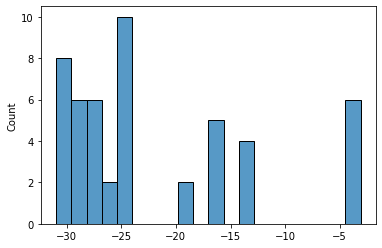

In [24]:
sns.histplot(np.log10(np.array(anti_thoersis_df.loc[:, 'e-value'])), bins = 20)

<AxesSubplot:xlabel='score', ylabel='Count'>

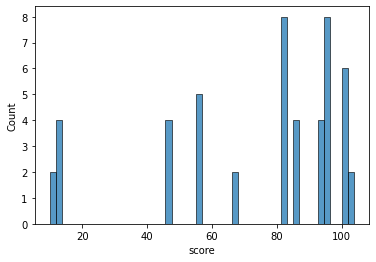

In [25]:
sns.histplot(anti_thoersis_df, x = 'score', bins= 50)

## anti-CRISPR

In [26]:
#go the input folder 
"/mnt/c/Users/Halewijn/OneDrive/Documenten/third year/BEP/thesis/phylogenetic_research/anti_defence_genes_phylogeny/input_data_database_in_faa"
#the working directory: 
"/mnt/c/Users/Halewijn/OneDrive/Documenten/third year/BEP/thesis/phylogenetic_research/anti_defence_genes_phylogeny/anti_RM_type_I"
#copy to the folder 
"""
for ii in *; do cp $ii "/mnt/c/Users/Halewijn/OneDrive/Documenten/third year/BEP/thesis/phylogenetic_research/anti_defence_genes_phylogeny/anti_RM_type_I/"$ii;done;
"""
#go to the folder
"/mnt/c/Users/Halewijn/OneDrive/Documenten/third year/BEP/thesis/phylogenetic_research/anti_defence_genes_phylogeny/anti_CRISPR"
#past the anti_RM genes in this folder
"""
for i in *.fasta; do echo $i; for ii in *.faa;do blastp -query $i -subject $ii -outfmt  "6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qcovs slen qlen" -out $i$ii.csv; done; done;"
"""

'\nfor i in *.fasta; do echo $i; for ii in *.faa;do blastp -query $i -subject $ii -outfmt  "6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qcovs slen qlen" -out $i$ii.csv; done; done;"\n'

In [27]:
result_folder = r'C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\phylogenetic_research\anti_defence_genes_phylogeny\anti_CRISPR'
files = os.listdir(result_folder)

#the column names
col_names = ["qseqid" , "sseqid",  "pident",  "length",  "mismatch",  "gapopen",  "qstart",  "qend",  "sstart",  "send", "evalue",  "bitscore",  "qcovs",  "slen", "qlen"]


csv_files = []
for ii in range(len(files)): 
    if files[ii].endswith('.csv'): 
        csv_files = csv_files + [files[ii]]

df_array = []
for ii in range(len(csv_files)): 
    result_csv_file = csv_files[ii]
    df = pd.read_csv(result_folder + '/' + result_csv_file, 
                    sep='\t',
                    names=col_names)
    df.loc[:, 'database ID'] = [result_csv_file]*df.shape[0]
    df_array = df_array + [df]
anti_CRISPR_df = pd.concat(df_array)
anti_CRISPR_df.loc[:, 'parent defence system'] = ['anti CRISPR']*anti_CRISPR_df.shape[0]
anti_CRISPR_df.to_csv('anti_CRISPR_df.csv', index = True)
#anti_CRISPR_df.loc[:, 'database ID'] = anti_CRISPR_df.loc[:, 'database ID'].str.extract('(?<=faa)(.*)(?=.fast)')

## anti-RM

In [28]:
#go the input folder 
"/mnt/c/Users/Halewijn/OneDrive/Documenten/third year/BEP/thesis/phylogenetic_research/anti_defence_genes_phylogeny/input_data_database_in_faa"
#the working directory: 
"/mnt/c/Users/Halewijn/OneDrive/Documenten/third year/BEP/thesis/phylogenetic_research/anti_defence_genes_phylogeny/anti_RM_type_I"
#copy to the folder 
"""
for ii in *; do cp $ii "/mnt/c/Users/Halewijn/OneDrive/Documenten/third year/BEP/thesis/phylogenetic_research/anti_defence_genes_phylogeny/anti_CRISPR/"$ii;done;
"""
#go to the folder
"/mnt/c/Users/Halewijn/OneDrive/Documenten/third year/BEP/thesis/phylogenetic_research/anti_defence_genes_phylogeny/anti_CRISPR"
#past the anti_RM genes in this folder
"""
for i in *.fasta; do echo $i; for ii in *.faa;do blastp -query $i -subject $ii -outfmt  "6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qcovs slen qlen" -out $i$ii.csv; done; done;
"""
#to test the gene mom
"for ii in *.faa;do blastp -query Mom.fasta -subject $ii - -out Mom.fasta.csv; done;"

'for ii in *.faa;do blastp -query Mom.fasta -subject $ii - -out Mom.fasta.csv; done;'

In [29]:
result_folder = r'C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\phylogenetic_research\anti_defence_genes_phylogeny\anti_RM_type_I'
files = os.listdir(result_folder)

#the column names
col_names = ["qseqid" , "sseqid",  "pident",  "length",  "mismatch",  "gapopen",  "qstart",  "qend",  "sstart",  "send", "evalue",  "bitscore",  "qcovs",  "slen", "qlen"]


csv_files = []
for ii in range(len(files)): 
    if files[ii].endswith('.csv'): 
        csv_files = csv_files + [files[ii]]

df_array = []
for ii in range(len(csv_files)): 
    result_csv_file = csv_files[ii]
    df = pd.read_csv(result_folder + '/' + result_csv_file, 
                    sep='\t',
                    names=col_names)
    df.loc[:, 'database ID'] = [result_csv_file]*df.shape[0]
    df_array = df_array + [df]
anti_RM_df = pd.concat(df_array)
anti_RM_df.loc[:, 'parent defence system'] = ['anti rm']*anti_RM_df.shape[0]
anti_RM_df.to_csv('anti_RM_df.csv', index = True)
#anti_RM_df.loc[:, 'database ID'] = anti_RM_df.loc[:, 'database ID'].str.extract('(?<=faa)(.*)(?=.fast)')

## NTase


In [30]:
#go the input folder 
"/mnt/c/Users/Halewijn/OneDrive/Documenten/third year/BEP/thesis/phylogenetic_research/anti_defence_genes_phylogeny/input_data_database_in_faa"
#the working directory: 
"/mnt/c/Users/Halewijn/OneDrive/Documenten/third year/BEP/thesis/phylogenetic_research/anti_defence_genes_phylogeny/anti_RM_type_I"
#copy to the folder 
"""
for ii in *; do cp $ii "/mnt/c/Users/Halewijn/OneDrive/Documenten/third year/BEP/thesis/phylogenetic_research/anti_defence_genes_phylogeny/nucleotidetransferase/"$ii;done;
"""
#go to the folder
"/mnt/c/Users/Halewijn/OneDrive/Documenten/third year/BEP/thesis/phylogenetic_research/anti_defence_genes_phylogeny/nucleotidetransferase"
#past the anti_RM genes in this folder
""""
for i in *.fasta; do echo $i; for ii in *.faa;do blastp -query $i -subject $ii  -outfmt  "6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qcovs slen qlen"  -out $i$ii.csv; done; done;
"""
#to test the gene mom

'"\nfor i in *.fasta; do echo $i; for ii in *.faa;do blastp -query $i -subject $ii  -outfmt  "6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qcovs slen qlen"  -out $i$ii.csv; done; done;\n'

In [31]:
result_folder = r'C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\phylogenetic_research\anti_defence_genes_phylogeny\nucleotidetransferase'
files = os.listdir(result_folder)

#the column names
col_names = ["qseqid" , "sseqid",  "pident",  "length",  "mismatch",  "gapopen",  "qstart",  "qend",  "sstart",  "send", "evalue",  "bitscore",  "qcovs",  "slen", "qlen"]


csv_files = []
for ii in range(len(files)): 
    if files[ii].endswith('.csv'): 
        csv_files = csv_files + [files[ii]]

df_array = []
for ii in range(len(csv_files)): 
    result_csv_file = csv_files[ii]
    df = pd.read_csv(result_folder + '/' + result_csv_file, 
                    sep='\t',
                    names=col_names)
    df.loc[:, 'database ID'] = [result_csv_file]*df.shape[0]
    df_array = df_array + [df]
NTase = pd.concat(df_array)
NTase.loc[:, 'parent defence system'] = ['nucleotidyltransferate']*NTase.shape[0]
NTase.to_csv('NTase.csv', index = True)

## Build Clinker result

In [4]:
#open environment
"conda activate clinkerenv"
#go to the directory
"/mnt/c/Users/Halewijn/OneDrive/Documenten/third year/BEP/thesis/phylogenetic_research/anti_defence_genes_phylogeny/clinker"
#run the following command


'/mnt/c/Users/Halewijn/OneDrive/Documenten/third year/BEP/thesis/phylogenetic_research/anti_defence_genes_phylogeny/clinker'

## Build tree: general

unique_IDs is based on the gravity result

In [5]:
nw = (r'C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\phylogenetic_research\build tree with anti defence genes\input data' + 
    '/' + 'gravity_result.nwk')
tree = Tree(nw, format=1) # newick subformat 1 to read internal node names
nodes_array = [tree.get_leaf_names()]
#nodes_array = pd.Dataframe(tree.get_leaf_names(), columns = ['leaf name']  ()      
unique_IDs = pd.DataFrame(nodes_array[0]).rename({0:'full ID name'}, axis = 1).groupby('full ID name').size().reset_index().loc[:, 'full ID name']

#rename the queries (query _____ PA25 for example)
#new_names = unique_IDs[unique_IDs.str.contains('Query')].str[12:]
#unique_IDs.iloc[new_names.index] = list(ne

all_IDs is based on the input database folder

In [6]:
database_folder = r'C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\phylogenetic_research\anti_defence_genes_phylogeny\input data database'
all_IDs_df = pd.DataFrame(os.listdir(database_folder)).rename({0:'file'}, axis = 1).reset_index()
all_IDs_df.loc[:, 'ID'] =  all_IDs_df.loc[:, 'file'].str[:-4]
full_ID_name_array = []
for ii in range(all_IDs_df.shape[0]): 
    ID = all_IDs_df.loc[ii, 'ID']
    hit = unique_IDs[unique_IDs.str.contains(ID)].reset_index()
    # if hit.shape[0] > 1: 
    #     hit = hit[hit.loc[:, 'full ID name'] == ID].reset_index()
    if hit.shape[0] == 0: 
        ID =  all_IDs_df.loc[ii, 'ID'].upper()
        hit = unique_IDs[unique_IDs.str.contains(ID)].reset_index()
    if hit.shape[0] > 1: 
        print(ID)
    last_index = hit.shape[0] -1
    full_ID_name_array = full_ID_name_array + [hit.loc[last_index, 'full ID name']]
all_IDs_df.loc[:,'full ID'] = full_ID_name_array
all_IDs_df = all_IDs_df[['file', 'ID', 'full ID']]

PA10
PA2
PA3
PA5
PA6


In [7]:
all_IDs_df.to_csv('all_IDs_df.csv')

In [ ]:
database_filepath = r'C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\phylogenetic_research\anti_defence_genes_phylogeny\input data database'
gbk_files = []
files = os.listdir(database_filepath)
for file in files: 
    if file.endswith('gbk'): 
        gbk_files = gbk_files + [file[0:-4]]
sequence_lengths = []
for ii in range(len(gbk_files)): 
    ID = gbk_files[ii]
    for seq_record in SeqIO.parse(database_filepath + '/' + ID + '.gbk', 'genbank'): 
        sequence_length = len(seq_record.seq)
    sequence_lengths += [sequence_length]

C:\Users\Halewijn\anaconda3\lib\site-packages\Bio\GenBank\Scanner.py:1218: BiopythonParserWarning: Premature end of file in sequence data
  warnings.warn(
C:\Users\Halewijn\anaconda3\lib\site-packages\Bio\GenBank\__init__.py:1380: BiopythonParserWarning: Expected sequence length 40739, found 16306 (AF115103.1).
  warnings.warn(


In [ ]:
genome_length_df = pd.DataFrame(sequence_lengths, columns=['genome length'])
genome_length_df.loc[:, 'ID'] = gbk_files

## Build VICTOR results

### build tree with own phages

In [10]:
own_tree = Tree(r'C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\phylogenetic_research\build tree with anti defence genes\input data' + 
    '/' + 'own_phage_tree.phy')
leafs = own_tree.get_leaf_names()
own_tree_df = pd.DataFrame(leafs, columns = ['original name'])
own_tree_df.loc[:, 'short leaf name'] =  own_tree_df.loc[:, 'original name'].str.extract('(?<=Pseudomonas_aeruginosa_)(.*)(?=@)')

#replace the names in the original.phy file
file = open(r'C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\phylogenetic_research\build tree with anti defence genes\input data' + 
    '/' + 'own_phage_tree.phy', 'r')
f = file.readlines()[0]
new_f = f
for ii in range(own_tree_df.shape[0]): 
    old_name = own_tree_df.loc[ii, 'original name']
    new_name = own_tree_df.loc[ii, 'short leaf name']
    new_f = new_f.replace(old_name, new_name)
    
#write the new file    
with open(r'C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\phylogenetic_research\build tree with anti defence genes\input data' + 
    '/' + 'short name own tree.phy', 'w') as f: 
    f.write(new_f)
    
#now, also make the colors 
own_tree_df =  pd.merge(own_tree_df, morphology_df, left_on = 'short leaf name', right_on='phage')


Myoviridae = rgb_to_hex(tuple(np.array(np.array(sns.color_palette(n_colors=10)[0])*255, dtype = 'int')))
Jumbo = rgb_to_hex(tuple(np.array(np.array(sns.color_palette(n_colors=10)[5])*255, dtype = 'int')))
Podoviridae = rgb_to_hex(tuple(np.array(np.array(sns.color_palette(n_colors=10)[1])*255, dtype = 'int')))
Siphoviridae = rgb_to_hex(tuple(np.array(np.array(sns.color_palette(n_colors=10)[2])*255, dtype = 'int')))
not_classified = rgb_to_hex(tuple(np.array(np.array(sns.color_palette(n_colors=10)[7])*255, dtype = 'int')))
# #map the colors
# morphology_dfmorphology_df.loc[:, 'color code'] = 
own_tree_df.loc[:, 'color'] =  own_tree_df.loc[:, 'morphology'].replace({'Myoviridae': Myoviridae, 'Podoviridae': Podoviridae, 'Siphoviridae': Siphoviridae, 'not classified': not_classified, 'Jumbo phage': Jumbo, 'P or S': not_classified})
# #write the file

filename = 'color_own_tree.txt'

with open(filename, 'w') as f: 
    f.write('')
with open(filename, 'a') as f: 

    # in order to make the other lines
    # def_filt_anti_thoersis_df =  filt_anti_thoersis_df[filt_anti_thoersis_df.loc[:, 'qseqid'] == defence_system].reset_index(drop = True)
    # for iiii in range(filt_anti_thoersis_df.shape[0]): 
    #     ID = filt_anti_thoersis_df.loc[iiii, 'full ID']
    #     f.write(ID + '\t') 
    #     f.write(str(1) + '\n')
    for ii in range(own_tree_df.shape[0]): 
        ID = own_tree_df.loc[ii, 'phage']
        color_code = own_tree_df.loc[ii, 'color']
        f.write(ID + '\t')
        f.write('#' + color_code + '\t' +'\n')

NameError: name 'morphology_df' is not defined

So first, we need to take all the labels of the gravity tree. Next, we filter on myo, podo, sipho. We also have to include our own phages. 

### find out the complete leaf names

Take all the labels of gravity

find out the IDs that contain pseudomonas and a morphology type, and also find out what the full ID name is

How many are podos and myos? 

In [ ]:
all_IDs_df.loc[:, 'Podoviridae'] = all_IDs_df.loc[:, 'full ID'].str.contains('Podoviridae')
all_IDs_df.loc[:, 'Siphoviridae'] = all_IDs_df.loc[:, 'full ID'].str.contains('Siphoviridae')
all_IDs_df.loc[:, 'Myoviridae'] = all_IDs_df.loc[:, 'full ID'].str.contains('Myoviridae')

In [ ]:
total_amount_of_phages = all_IDs_df.shape[0]
Myoviridae_percentage = all_IDs_df.loc[:, 'Myoviridae'].sum()/total_amount_of_phages*100
Podoviridae_percentage = all_IDs_df.loc[:, 'Podoviridae'].sum()/total_amount_of_phages*100
Siphoviridae_percentage = all_IDs_df.loc[:, 'Siphoviridae'].sum()/total_amount_of_phages*100
Siphoviridae_percentage

filter on pseudomonas phages

In [ ]:
pseudomonas_IDs = all_IDs_df[(all_IDs_df.loc[:, 'full ID'].str.contains('Myoviridae') | all_IDs_df.loc[:, 'full ID'].str.contains('Siphoviridae') | all_IDs_df.loc[:, 'full ID'].str.contains('Podoviridae')) 
           & (all_IDs_df.loc[:, 'full ID'].str.contains('Pseudomonas'))]
pseudomonas_IDs.loc[:, 'Podoviridae'] = pseudomonas_IDs.loc[:, 'full ID'].str.contains('Podoviridae')
pseudomonas_IDs.loc[:, 'Siphoviridae'] = pseudomonas_IDs.loc[:, 'full ID'].str.contains('Siphoviridae')
pseudomonas_IDs.loc[:, 'Myoviridae'] = pseudomonas_IDs.loc[:, 'full ID'].str.contains('Myoviridae')

copy the files database files to the VICTOR tree

In [ ]:
data_base_folder = r'C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\phylogenetic_research\anti_defence_genes_phylogeny\input data database'

#myoviridae
#copy the database
dest_folder = r'C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\phylogenetic_research\anti_defence_genes_phylogeny\VICTOR tree\Myoviridae'
Myoviridae_df = pseudomonas_IDs[pseudomonas_IDs.loc[:, 'Myoviridae']].reset_index(drop = True)
for ii in range(Myoviridae_df.shape[0]):
    filename = Myoviridae_df.loc[ii, 'file']
    
    shutil.copy2(data_base_folder + '/' + filename, dest_folder + '/' + filename)
#copy the phages

#podoviridae
dest_folder = r'C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\phylogenetic_research\anti_defence_genes_phylogeny\VICTOR tree\Podoviridae'
Podoviridae_df = pseudomonas_IDs[pseudomonas_IDs.loc[:, 'Podoviridae']].reset_index(drop = True)
for ii in range(Podoviridae_df.shape[0]):
    filename = Podoviridae_df.loc[ii, 'file']
    shutil.copy2(data_base_folder + '/' + filename, dest_folder + '/' + filename)
    
#podoviridae
dest_folder = r'C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\phylogenetic_research\anti_defence_genes_phylogeny\VICTOR tree\Siphoviridae'
Siphoviridae_df = pseudomonas_IDs[pseudomonas_IDs.loc[:, 'Siphoviridae']].reset_index(drop = True)
for ii in range(Siphoviridae_df.shape[0]):
    filename = Siphoviridae_df.loc[ii, 'file']
    shutil.copy2(data_base_folder + '/' + filename, dest_folder + '/' + filename)

### Build myo tree for stealth

We need shorter names. So we import the Myo tree, and make the leaf name shorter using regex expressions

In [79]:
anti_RADAR_df = stealth_df

nw = (r'C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\phylogenetic_research\build tree with anti defence genes\input data' + 
    '/' + 'Myoviridae tree.phy')
myo_tree = Tree(nw) # newick subformat 1 to read internal node names

myo_df = pd.DataFrame(myo_tree.get_leaf_names(), columns = ['leaf name'])
#extract the short name. It is 2 times after a _ and then take everything before @
myo_df.loc[:, 'short name'] = myo_df.loc[:, 'leaf name'].str.extract('\_(.*)').loc[:, 0]#.str.extract('(.*?)(@)')#.loc[:, 0].str.extract('\@(.*)')
myo_df.loc[:, 'short name'] =  myo_df.loc[:, 'short name'].str.extract('(?<=)(.*?)(?=@)').loc[:, 0]
our_phages = myo_df.loc[:, 'short name'].str.startswith('aeruginosa')
myo_df[our_phages == True]
myo_df.loc[:, 'short name'].replace({'phage_': '', })
myo_df.loc[:, 'short name'] = myo_df.loc[:, 'short name'].str.replace('phage_', '').str.replace('aeruginosa_', '')

#replace the names in the original.phy file
file = open(nw, 'r')
f = file.readlines()[0]
new_f = f
for ii in range(myo_df.shape[0]): 
    old_name = myo_df.loc[ii, 'leaf name']
    new_name = myo_df.loc[ii, 'short name']
    new_f = new_f.replace(old_name, new_name)
#write the new file    
with open(r'C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\phylogenetic_research\build tree with anti defence genes\input data' + 
    '/' + 'short name Myoviridae tree.phy', 'w') as f: 
    f.write(new_f)

#read the new nodes from the .phy file, and determine which are our phages
new_myo_tree = Tree(r'C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\phylogenetic_research\build tree with anti defence genes\input data' + 
    '/' + 'short name Myoviridae tree.phy')
new_myo_df = pd.DataFrame(new_myo_tree.get_leaf_names(), columns = ['leaf name'])
#make the colors if the phage is present in our dataset
present_color = rgb_to_hex(tuple(np.array(np.array(sns.color_palette(n_colors=10, palette = 'Pastel1')[2])*255, dtype = 'int')))
present_color = 'bd0026'
not_present_color = rgb_to_hex(tuple(np.array(np.array(sns.color_palette(n_colors=10, palette = 'Pastel1')[0])*255, dtype = 'int')))
not_present_color = 'fed976'
#make the colors appear in the tree, so make the dataset
with open('presence_of_phages_in_myoviridae_tree.txt', 'w') as f: 
    for ii in range(new_myo_df.shape[0]): 
        leaf_name = new_myo_df.loc[ii, 'leaf name']
        color = not_present_color
        if leaf_name in phage_order: 
            color = present_color
        f.write(leaf_name + '\t' + '#' + color +  '\t' + '\n')
        
#set filtering parameters 
evalue = 0.001
pident =  40

#For HMM search, the criterium will be: 
hmm_evalue = 1e-20
hmm_score = 40

filt_anti_RADAR_df = anti_RADAR_df[(anti_RADAR_df.loc[:, 'pident'] > 40) & (anti_RADAR_df.loc[:, 'evalue'] < evalue)] #filter on anti RADAR 
anti_RADAR_hits_ID = filt_anti_RADAR_df.loc[:, 'database ID'].str[:-8].reset_index() #take the IDs of the hits of anti RADAR
anti_RADAR_full_name = pd.merge(anti_RADAR_hits_ID, all_IDs_df[['ID', 'full ID']], left_on='database ID', right_on='ID').drop(['database ID', 'index'], axis = 1) #find the full name of the gravity result
#find the hits in the myo tree
hits_in_myo_tree_array = []
for ii in range(anti_RADAR_full_name.shape[0]): 
    ID = anti_RADAR_full_name.loc[ii, 'ID']
    same_ID_in_tree = myo_df[myo_df.loc[:, 'leaf name'].str.contains(ID)].reset_index()
    try:
        hits_in_myo_tree_array = hits_in_myo_tree_array + [same_ID_in_tree.loc[0, 'leaf name']]
    except: 
        continue
#pd.DataFrame(hits_in_myo_tree_array, columns = 'VICTOR na')
present_color = rgb_to_hex(tuple(np.array(np.array(sns.color_palette(n_colors=10)[2])*255, dtype = 'int')))
present_color = '08519c'
not_present_color = rgb_to_hex(tuple(np.array(np.array(sns.color_palette(n_colors=10)[3])*255, dtype = 'int')))
not_present_color = 'c6dbef'
anti_RADAR_in_victor_results = myo_df[myo_df.loc[:, 'leaf name'].isin(hits_in_myo_tree_array)]
anti_RADAR_in_victor_results.loc[:, 'color'] = [present_color]*anti_RADAR_in_victor_results.shape[0]
final_df = pd.merge(myo_df, anti_RADAR_in_victor_results, 'outer')
final_df.loc[:, 'color'] =  final_df.loc[:, 'color'].replace(np.NaN, not_present_color)

with open('anti_RADAR_in_myoviridae_tree', 'w') as f:
#finally
    for ii in range(final_df.shape[0]): 
        name = final_df.loc[ii, 'short name']
        color = final_df.loc[ii, 'color']
        f.write(name + '\t' + '#' + color + '\t' + '\n')
#next, find out where RADAR is in this specific tree. We can perhaps merge the IDs from the gravity, with these ones.

C:\Users\Halewijn\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


### Build podotree for stealth

In [ ]:
nw = (r'C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\phylogenetic_research\build tree with anti defence genes\input data' + 
    '/' + 'Podoviridae tree.phy')
podo_tree = Tree(nw) # newick subformat 1 to read internal node names

podo_df = pd.DataFrame(podo_tree.get_leaf_names(), columns = ['leaf name'])
#extract the short name. It is 2 times after a _ and then take everything before @
podo_df.loc[:, 'short name'] = podo_df.loc[:, 'leaf name'].str.extract('\_(.*)').loc[:, 0]#.str.extract('(.*?)(@)')#.loc[:, 0].str.extract('\@(.*)')
podo_df.loc[:, 'short name'] =  podo_df.loc[:, 'short name'].str.extract('(?<=)(.*?)(?=@)').loc[:, 0]
our_phages = podo_df.loc[:, 'short name'].str.startswith('aeruginosa')
podo_df[our_phages == True]
podo_df.loc[:, 'short name'].replace({'phage_': '', })
podo_df.loc[:, 'short name'] = podo_df.loc[:, 'short name'].str.replace('phage_', '').str.replace('aeruginosa_', '')

#replace the names in the original.phy file
file = open(nw, 'r')
f = file.readlines()[0]
new_f = f
for ii in range(podo_df.shape[0]): 
    old_name = podo_df.loc[ii, 'leaf name']
    new_name = podo_df.loc[ii, 'short name']
    new_f = new_f.replace(old_name, new_name)
#write the new file    
with open(r'C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\phylogenetic_research\build tree with anti defence genes\input data' + 
    '/' + 'short name Podoviridae tree.phy', 'w') as f: 
    f.write(new_f)

#read the new nodes from the .phy file, and determine which are our phages
new_podo_tree = Tree(r'C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\phylogenetic_research\build tree with anti defence genes\input data' + 
    '/' + 'short name Podoviridae tree.phy')
new_podo_df = pd.DataFrame(new_podo_tree.get_leaf_names(), columns = ['leaf name'])
#make the colors
present_color = rgb_to_hex(tuple(np.array(np.array(sns.color_palette(n_colors=10, palette = 'Pastel1')[2])*255, dtype = 'int')))
not_present_color = rgb_to_hex(tuple(np.array(np.array(sns.color_palette(n_colors=10, palette = 'Pastel1')[0])*255, dtype = 'int')))
#make the colors appear in the tree, so make the dataset
with open('presence_of_phages_in_podoviridae_tree.txt', 'w') as f: 
    for ii in range(new_podo_df.shape[0]): 
        leaf_name = new_podo_df.loc[ii, 'leaf name']
        color = not_present_color
        if leaf_name in phage_order: 
            color = present_color
        f.write(leaf_name + '\t' + '#' + color +  '\t' + '\n')
        
#set filtering parameters 
evalue = 0.001
pident =  40

#For HMM search, the criterium will be: 
hmm_evalue = 1e-20
hmm_score = 40

filt_anti_RADAR_df = anti_RADAR_df[(anti_RADAR_df.loc[:, 'pident'] > 40) & (anti_RADAR_df.loc[:, 'evalue'] < evalue)] #filter on anti RADAR 
anti_RADAR_hits_ID = filt_anti_RADAR_df.loc[:, 'database ID'].str[:-8].reset_index() #take the IDs of the hits of anti RADAR
anti_RADAR_full_name = pd.merge(anti_RADAR_hits_ID, all_IDs_df[['ID', 'full ID']], left_on='database ID', right_on='ID').drop(['database ID', 'index'], axis = 1) #find the full name of the gravity result
#find the hits in the podo tree
hits_in_podo_tree_array = []
for ii in range(anti_RADAR_full_name.shape[0]): 
    ID = anti_RADAR_full_name.loc[ii, 'ID']
    same_ID_in_tree = podo_df[podo_df.loc[:, 'leaf name'].str.contains(ID)].reset_index()
    try:
        hits_in_podo_tree_array = hits_in_podo_tree_array + [same_ID_in_tree.loc[0, 'leaf name']]
    except: 
        continue
present_color = rgb_to_hex(tuple(np.array(np.array(sns.color_palette(n_colors=10)[2])*255, dtype = 'int')))
not_present_color = rgb_to_hex(tuple(np.array(np.array(sns.color_palette(n_colors=10)[3])*255, dtype = 'int')))
anti_RADAR_in_victor_results = podo_df[podo_df.loc[:, 'leaf name'].isin(hits_in_podo_tree_array)]
anti_RADAR_in_victor_results.loc[:, 'color'] = [present_color]*anti_RADAR_in_victor_results.shape[0]
final_df = pd.merge(podo_df, anti_RADAR_in_victor_results, 'outer')
final_df.loc[:, 'color'] =  final_df.loc[:, 'color'].replace(np.NaN, not_present_color)

with open('anti_RADAR_in_podoviridae_tree', 'w') as f:
#finally
    for ii in range(final_df.shape[0]): 
        name = final_df.loc[ii, 'short name']
        color = final_df.loc[ii, 'color']
        f.write(name + '\t' + '#' + color + '\t' + '\n')
#next, find out where RADAR is in this specific tree. We can perhaps merge the IDs from the gravity, with these ones.

## Build gravity tree

Our filter criterium will be: 

for Blastp
- evalue < 0.01
- pident > 30

For HMM search, the criterium will be: 
- evalue < 1e-20
- score > 40

### find out which are our phages

In [8]:
our_phages = list(unique_IDs[unique_IDs.str.contains('Query')].reset_index(drop = True))
with open('our_phages_gravity.txt', 'w') as f:
    f.write('')

for ID in unique_IDs: 
    color = '252525'
    if ID in our_phages: 
        color = 'f7f7f7'
    with open('our_phages_gravity.txt', 'a') as f: 
        f.write(ID + '\t' + '#' + color + '\t'+ '\n')

### find out their nature

In [13]:
virulence_df = pd.merge(pd.merge(unique_IDs.str.extract('(.*?)_').rename({0: 'ID'}, axis = 1), pd.read_csv('phageAI_NCBI_phagesv2.csv')[['Acc no.', 'Phage']].rename({'Acc no.': 'ID'}, axis = 1)), all_IDs_df[['ID', 'full ID']])
virulence_df.loc[:, 'Phage'].unique()
colormap = {'Temperate': 'fcbba1', 'Virulent': 'a50f15'}
virulence_df.loc[:, 'color'] =  virulence_df.loc[:, 'Phage'].map(colormap)
with open('gravity virulence.txt', 'w') as f: 
    f.write('')
virulence_df = virulence_df.reset_index(drop = True)
for ii in range(virulence_df.shape[0]): 
    full_name = virulence_df.loc[ii, 'full ID']
    color = virulence_df.loc[ii, 'color']
    with open('gravity virulence.txt', 'a') as f: 
        f.write(full_name+'\t' + '#' + color + '\t' + '\n')

### for blastp search

C:\Users\Halewijn\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(-20.0, 10.0)

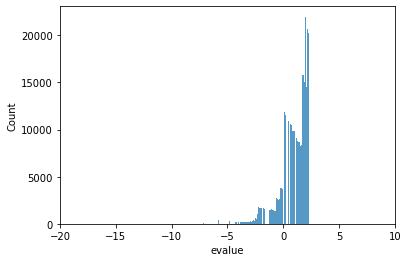

In [16]:
#load in the data 
anti_CBASS_type_I_df = pd.read_csv('anti_CBASS_type_I_df.csv')
anti_CBASS_type_II_df = pd.read_csv('anti_CBASS_type_II_df.csv')
anti_pycsar_df = pd.read_csv('anti_pycsar_df.csv')
stealth_df = pd.read_csv('stealth_df.csv')
anti_CRISPR_df = pd.read_csv('anti_CRISPR_df.csv')
anti_RM_df = pd.read_csv('anti_RM_df.csv')
NTase = pd.read_csv('NTase.csv')

#concatenate and filter
all_hits = pd.concat([anti_CBASS_type_I_df, anti_CBASS_type_II_df,anti_pycsar_df, stealth_df, anti_CRISPR_df, anti_RM_df, NTase])
all_hits.to_csv('all hits.csv', index = False)
#sns.histplot(data = all_hits, x = 'evalue')
sns.histplot(np.log(all_hits.loc[:, 'evalue']))
plt.xlim(-20,10)

In [17]:
evalue = 0.001
pident =  40

#For HMM search, the criterium will be: 
hmm_evalue = 1e-20
hmm_score = 40

In [18]:


filt_all_hits = all_hits[(all_hits.loc[:, 'evalue'] <= evalue) & (all_hits.loc[:, 'pident'] > pident)].reset_index()
# filt_all_hits = filt_all_hits.reset_index(drop = True)
filt_all_hits.loc[:,'special new database ID'] =  filt_all_hits.loc[:, 'database ID'].str.extract('(?<=fasta)(.*)')
filt_all_hits.loc[:, 'special new database ID'] = filt_all_hits.loc[:, 'special new database ID'].replace(np.NaN, '')
mask = filt_all_hits.loc[:, 'database ID'].str.contains('fasta')
filt_all_hits[mask].loc[:, 'database ID'] = filt_all_hits.loc[:, 'special new database ID'] = filt_all_hits.loc[mask, 'special new database ID']
filt_all_hits.loc[:, 'special new database ID'] =  filt_all_hits.loc[:, 'special new database ID'].replace(np.NaN, '')
# filt_all_hits
#filt_all_hits = filt_all_hits.drop('database ID', axis = 1)
#filt_all_hits = filt_all_hits.rename({'special new database ID': ''})
#filt_all_hits
filt_all_hits.loc[mask, 'database ID'] = ['']*filt_all_hits.loc[mask, 'database ID'].shape[0]
filt_all_hits.loc[:, 'database ID'] = filt_all_hits.loc[:, 'database ID'] + filt_all_hits.loc[:, 'special new database ID']
filt_all_hits.loc[:,'new database ID'] =  filt_all_hits.loc[:, 'database ID'].str[:-8]

#merge to get the full name 
filt_all_hits =  pd.merge(filt_all_hits, all_IDs_df, left_on = 'new database ID', right_on = 'ID')

C:\Users\Halewijn\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [14]:
filt_all_hits.groupby('parent defence system').size()

parent defence system
anti CBASS type I          154
anti CBASS type II           5
anti CRISPR                 39
anti rm                     81
nucleotidyltransferate    4257
stealth                     23
dtype: int64

In [147]:
# #annotate the full name to each unique ID
# full_labels = pd.DataFrame(unique_IDs)
# full_names_array = []

# for ii in range(filt_all_hits.shape[0]): 
    
#     short_ID = filt_all_hits.loc[ii, 'new database ID']

#     full_name_df = full_labels[full_labels.loc[:, 'full ID name'].str.contains(short_ID)].reset_index()
        
#     if full_name_df.shape[0] > 1: 
#         print('woops dubble hit')
#     if full_name_df.shape[0] == 0:
#         print(short_ID)
#         print('woops no full name found')
#     try: 
#         full_name = full_name_df.loc[0, 'full ID name']
#         full_names_array = full_names_array + [full_name]
#     except: 
#         full_names_array = full_names_array + ['']
# #put the full IDs in the dataframe
# filt_all_hits.loc[:, 'full ID'] = full_names_array

In [148]:
defence_systems = filt_all_hits.loc[:, 'parent defence system'].unique()
num_defence_systems = len(defence_systems)
color= rgb_to_hex(tuple(np.array(np.array(sns.color_palette(n_colors=10, palette = 'tab20b')[0])*255, dtype = 'int')))

for defence_system in defence_systems: 
    print(defence_system)
    filename = 'build_tree_file_' + defence_system + '.txt'

    with open(filename, 'w') as f: 
        f.write('')
    with open(filename, 'a') as f: 
        #in order to make the other lines
        def_filt_all_hits =  filt_all_hits[filt_all_hits.loc[:, 'parent defence system'] == defence_system].reset_index(drop = True)
        def_filt_all_hits =  def_filt_all_hits.groupby(['full ID'], as_index = False).size()
        for iiii in range(def_filt_all_hits.shape[0]): 
            ID = def_filt_all_hits.loc[iiii, 'full ID']
            f.write(str(ID) + '\t') 
            f.write('#' + color  + '\t' + '\n')


anti CBASS type I
anti rm
nucleotidyltransferate
anti CRISPR
anti CBASS type II
stealth


#### for stealth

In [77]:
#df = pd.merge(filt_anti_RADAR_df[['shorter database ID']], all_IDs_df[['ID', 'full ID']], left_on='shorter database ID', right_on = 'ID')
#stealth_IDs = df.loc[:, 'full ID']
# for ii in range(df.shape[0]): 
#     color = 
with open('gravity stealth presence.txt', 'w') as f: 
    f.write('')
stealth_IDs = list(filt_all_hits[filt_all_hits.loc[:, 'parent defence system'] == 'stealth'][['ID']].loc[:, 'ID'])
for ii in range(all_IDs_df.shape[0]): 
    ID = all_IDs_df.loc[ii, 'ID']
    full_ID = all_IDs_df.loc[ii, 'full ID']
    color = '9ecae1'
    if ID in stealth_IDs: 
        color = '08519c'
    with open('gravity stealth presence.txt', 'a') as f: 
        f.write(full_ID + '\t' + '#' + color + '\t' + '\n')

In [35]:
full_labels = pd.DataFrame(unique_IDs)
full_names_array = []

for ii in range(filt_anti_RADAR_df.shape[0]): 
    
    short_ID = filt_anti_RADAR_df.loc[ii, 'new database ID']
    full_name_df = full_labels[full_labels.loc[:, 'full ID name'].str.contains(short_ID)].reset_index()
    if full_name_df.shape[0] > 1: 
        print('woops dubble hit')
    if full_name_df.shape[0] == 0:
        print(short_ID)
        print('woops no full name found')
    try: 
        full_name = full_name_df.loc[0, 'full ID name']
        full_names_array = full_names_array + [full_name]
    except: 
        full_names_array = full_names_array + ['']
#put the full IDs in the dataframe
filt_anti_RADAR_df.loc[:, 'full ID'] = full_names_array

KeyError: 0

In [32]:
filt_anti_RADAR_df.loc[:, 'shorter database ID'] = filt_anti_RADAR_df.loc[:, 'database ID'].str[:-8]
percentage_df = pd.merge(filt_anti_RADAR_df[['evalue','pident','shorter database ID', 'sseqid']], all_IDs_df[['ID', 'full ID', 'Podoviridae', 'Myoviridae', 'Siphoviridae']],
        left_on = 'shorter database ID', right_on = 'ID')
#percentage_df.iloc[[17,18,19,20]].loc[:, 'Myoviridae'] = [True]*4
percentage_df.loc[[17,18,19,20], 'Myoviridae'] = [True]*4
percentage_myo = percentage_df.loc[:, 'Myoviridae'].sum()/percentage_df.shape[0]
percentage_podo = percentage_df.loc[:, 'Podoviridae'].sum()/percentage_df.shape[0]
print(percentage_myo)
print(percentage_podo)

C:\Users\Halewijn\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


KeyError: "['Podoviridae', 'Myoviridae', 'Siphoviridae'] not in index"

In [33]:
color= rgb_to_hex(tuple(np.array(np.array(sns.color_palette(n_colors=10, palette = 'tab20b')[0])*255, dtype = 'int')))
defence_system = 'anti_RADAR'
filename = 'build_tree_file_' + 'stealth' + '.txt'

with open(filename, 'w') as f: 
    f.write('')
with open(filename, 'a') as f: 
    #in order to make the other lines
    def_filt_anti_RADAR_df =  filt_anti_RADAR_df[filt_anti_RADAR_df.loc[:, 'qseqid'] == defence_system].reset_index(drop = True)
    for iiii in range(def_filt_anti_RADAR_df.shape[0]): 
        ID = def_filt_anti_RADAR_df.loc[iiii, 'full ID']
        f.write(ID + '\t') 
        f.write('#' + color  + '\t' + '\n')

KeyError: 'full ID'

### for  anti_RM 

In [ ]:
anti_RM_df.loc[:, 'anti gene'] =  anti_RM_df.loc[:, 'database ID'].str.extract('(?<=faa)(.*)(?=.fast)').loc[:,0]
anti_RM_df.loc[:, 'ID'] =  anti_RM_df.loc[:, 'database ID'].str.extract('(?<=)(.*?)(?=.faa)').loc[:,0]
filt_anti_RM_df =  anti_RM_df[(anti_RM_df.loc[:, 'pident'] > 30) & (anti_RM_df.loc[:, 'evalue'] < 0.01)].reset_index(drop = True)

In [ ]:
full_labels = pd.DataFrame(unique_IDs)
full_names_array = []

for ii in range(filt_anti_RM_df.shape[0]): 
    
    short_ID = filt_anti_RM_df.loc[ii, 'ID'].upper()
    print(short_ID)
    full_name_df = full_labels[full_labels.loc[:, 'full ID name'].str.contains(short_ID)].reset_index()
    if full_name_df.shape[0] > 1: 
        print('woops dubble hit')
    if full_name_df.shape[0] == 0:
        print('woops no full name found')
    full_name = full_name_df.loc[0, 'full ID name']
    full_names_array = full_names_array + [full_name]
    
#put the full IDs in the dataframe
filt_anti_RM_df.loc[:, 'full ID'] = full_names_array

In [ ]:
defence_systems = filt_anti_thoersis_df.loc[:, 'anti gene'].unique()
num_defence_systems = len(defence_systems)

filename = 'build_tree_file_' + 'anti_RM' + '.txt'

with open(filename, 'w') as f: 
    f.write('')
with open(filename, 'a') as f: 

    #in order to make the other lines
    #def_filt_anti_thoersis_df =  filt_anti_thoersis_df[filt_anti_thoersis_df.loc[:, 'qseqid'] == defence_system].reset_index(drop = True)
    for iiii in range(filt_anti_thoersis_df.shape[0]): 
        ID = filt_anti_thoersis_df.loc[iiii, 'full ID']
        f.write(ID + '\t') 
        f.write(str(1) + '\n')

#         for iiii in range(num_defence_systems): 

### for anti_thoersis

In [ ]:
filt_anti_thoersis_df = anti_thoersis_df[(anti_thoersis_df.loc[:, 'e-value'] < hmm_evalue) & (anti_thoersis_df.loc[:, 'score'] > hmm_score)].reset_index(drop = True)
filt_anti_thoersis_df.loc[:,'ID'] = filt_anti_thoersis_df.loc[:, 'database ID'].str.extract('(?<=aln.hmm)(.*)(?=.faata)').loc[:, 0].str[1:]

In [ ]:
full_labels = pd.DataFrame(unique_IDs)
full_names_array = []

for ii in range(filt_anti_thoersis_df.shape[0]): 
    
    short_ID = filt_anti_thoersis_df.loc[ii, 'ID']
    full_name_df = full_labels[full_labels.loc[:, 'full ID name'].str.contains(short_ID)].reset_index()
    if full_name_df.shape[0] > 1: 
        print('woops dubble hit')
    if full_name_df.shape[0] == 0:
        print('woops no full name found')
    full_name = full_name_df.loc[0, 'full ID name']
    full_names_array = full_names_array + [full_name]
    
#put the full IDs in the dataframe
filt_anti_thoersis_df.loc[:, 'full ID'] = full_names_array

In [ ]:
filename = 'build_tree_file_' + 'anti_thoersis' + '.txt'

with open(filename, 'w') as f: 
    f.write('')
with open(filename, 'a') as f: 

    #in order to make the other lines
    #def_filt_anti_thoersis_df =  filt_anti_thoersis_df[filt_anti_thoersis_df.loc[:, 'qseqid'] == defence_system].reset_index(drop = True)
    for iiii in range(filt_anti_thoersis_df.shape[0]): 
        ID = filt_anti_thoersis_df.loc[iiii, 'full ID']
        f.write(ID + '\t') 
        f.write(str(1) + '\n')

### Make color strip that reflects how many anti-defence genes a phage has

In [39]:
filt_all_hits.loc[:, 'new database ID']
df = filt_all_hits.groupby(['new database ID', 'parent defence system'], as_index = False).size().groupby('new database ID', as_index = False).size().sort_values('size', ascending = False)
#filt_all_hits[filt_all_hits.loc[:, 'new database ID'] == 'AB897757']#.loc[:, 'parent defence system']
df = pd.merge(df, all_IDs_df, left_on = 'new database ID', right_on = 'ID')
colormap = {1: 'ffffb2', 2: 'feb24c', 3:'f03b20', 4:'f03b20'}
df.loc[:, 'color'] =  df.loc[:, 'size'].map(colormap)
df = df.reset_index(drop = True)
with open('number of defence systems gravity.txt', 'w') as f: 
    f.write('')
for ii in range(df.shape[0]): 
    full_ID = df.loc[ii, 'full ID']
    color = df.loc[ii, 'color']
    with open('number of defence systems gravity.txt', 'a') as f: 
        f.write(full_ID + '\t' + '#' + color + '\t' + '\n')

### make the phylogeny

In [485]:
gravity_morphology_df

,full ID name,morphology
0,AB008550_Myoviridae_Peduovirus_Pseudomonas_pha...,Myoviridae
1,AB045978_Siphoviridae_Triavirus_Staphylococcus...,Siphoviridae
2,AB063393_Sphaerolipoviridae_Gammasphaerolipovi...,not classified
3,AB231700_Myoviridae__Microcystis_phage_Ma_LMM01,Myoviridae
4,AB243556_Siphoviridae_Biseptimavirus_Staphyloc...,Siphoviridae
...,...,...
1364,X07234_Fuselloviridae_Alphafusellovirus_sulfol...,not classified
1365,X96987_Podoviridae_Salasvirus_Bacillus_phage_GA1,Podoviridae
1366,X99260_Podoviridae_Salasvirus_Bacillus_phage_B103,Podoviridae
1367,Z18946_Siphoviridae_Fromanvirus_Mycobacterium_...,Siphoviridae


In [490]:
#I will classify all the phages in Podo, myo and sipho
gravity_morphology_df =  pd.DataFrame(unique_IDs)
#gravity_morphology_df.loc[:,'Podoviridae'] = 
#indexes = 
gravity_morphology_df.loc[:, 'morphology'] =  gravity_morphology_df.loc[:, 'full ID name'].str.contains('Myoviridae')
gravity_morphology_df.loc[:, 'morphology'] =  gravity_morphology_df.loc[:, 'morphology'].replace({True: 'Myoviridae', False: ''})
#podoviridae
gravity_morphology_df.loc[:, 'morphology'] = gravity_morphology_df.loc[:, 'morphology'] +  gravity_morphology_df.loc[:, 'full ID name'].str.contains('Podoviridae').replace({True: 'Podoviridae', False: ''})
#myoviridae
gravity_morphology_df.loc[:, 'morphology'] = gravity_morphology_df.loc[:, 'morphology'] +  gravity_morphology_df.loc[:, 'full ID name'].str.contains('Siphoviridae').replace({True: 'Siphoviridae', False: ''})
#unclassified results
gravity_morphology_df.loc[:, 'morphology'] = gravity_morphology_df.loc[:, 'morphology'] + pd.Series(gravity_morphology_df.loc[:, 'morphology'] == '').map({True: 'not classified', False: ''})
gravity_morphology_df =  pd.merge(gravity_morphology_df, all_IDs_df, left_on = 'full ID name', right_on = 'full ID').drop('full ID name', axis = 1)

In [22]:
Myoviridae = rgb_to_hex(tuple(np.array(np.array(sns.color_palette(n_colors=10)[0])*255, dtype = 'int')))
Podoviridae = rgb_to_hex(tuple(np.array(np.array(sns.color_palette(n_colors=10)[1])*255, dtype = 'int')))
Siphoviridae = rgb_to_hex(tuple(np.array(np.array(sns.color_palette(n_colors=10)[2])*255, dtype = 'int')))
not_classified = rgb_to_hex(tuple(np.array(np.array(sns.color_palette(n_colors=10)[7])*255, dtype = 'int')))

Myoviridae = '74a9cf'
Podoviridae = 'fec44f'
Siphoviridae = 'de2d26'
not_classified = '969696'

#map the colors
gravity_morphology_df.loc[:, 'color code'] =  gravity_morphology_df.loc[:, 'morphology'].replace({'Myoviridae': Myoviridae, 'Podoviridae': Podoviridae, 'Siphoviridae': Siphoviridae, 'not classified': not_classified})
#write the file

filename = 'color_code_tree.txt'

with open(filename, 'w') as f: 
    f.write('')
with open(filename, 'a') as f: 

    #in order to make the other lines
    #def_filt_anti_thoersis_df =  filt_anti_thoersis_df[filt_anti_thoersis_df.loc[:, 'qseqid'] == defence_system].reset_index(drop = True)
    # for iiii in range(filt_anti_thoersis_df.shape[0]): 
    #     ID = filt_anti_thoersis_df.loc[iiii, 'full ID']
    #     f.write(ID + '\t') 
    #     f.write(str(1) + '\n')
    for ii in range(gravity_morphology_df.shape[0]): 
        ID = gravity_morphology_df.loc[ii, 'full ID name']
        color_code = gravity_morphology_df.loc[ii, 'color code']
        f.write(ID + '\t')
        f.write('#' + color_code + '\t' +'\n')
        

### See if anti-defence genes are specific too a morphology

In [23]:
#df = filt_all_hits.groupby(['new database ID', 'parent defence system'], as_index = False).size().groupby('new database ID', as_index = False).size().sort_values('size', ascending = False)

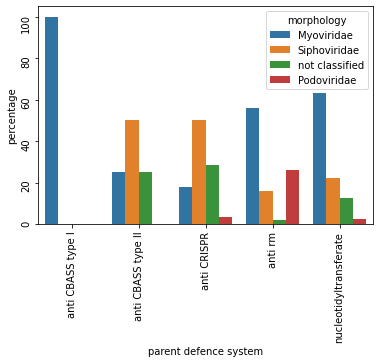

In [214]:
filt_all_hits.loc[:, 'parent defence system'].unique()
a = filt_all_hits.groupby(['ID', 'parent defence system'], as_index = False).size().groupby('ID', as_index = False).size().sort_values('size', ascending = False).rename({'size': 'num antigenes'}, axis = 1)
a.groupby('num antigenes', as_index = False).size()#.loc[:, 'size'].sum()
a = pd.merge(filt_all_hits.groupby(['parent defence system', 'new database ID'], as_index = False).size()[['parent defence system', 'new database ID']], all_IDs_df[['ID', 'full ID']], left_on='new database ID', right_on='ID').drop('new database ID', axis = 1)
b = pd.merge(a, gravity_morphology_df[['morphology', 'full ID name']], left_on='full ID', right_on='full ID name').drop('full ID name', axis =1).drop(['full ID', 'ID'], axis = 1)

c = pd.merge(b.groupby(['parent defence system', 'morphology'], as_index = False).size(), b.groupby(['parent defence system'], as_index = False).size().rename({'size': 'total number'}, axis = 1))
c.loc[:, 'percentage'] = c.loc[:, 'size']/c.loc[:, 'total number']*100
c = c[['parent defence system', 'morphology', 'percentage']]
c
sns.barplot(data = c[c.loc[:, 'parent defence system'] != 'stealth'], hue = 'morphology', y = 'percentage', x = 'parent defence system')
ax = plt.gca()
ax.tick_params(rotation=90)
plt.savefig(r'C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\figures\supplementary' + '/' + 'distribution of occurence of anti_defence_systems', bbox_inches = 'tight')
plt.show()

In [453]:
a

,parent defence system,ID,full ID name,morphology
0,anti CBASS type I,AF158101,AF158101_Myoviridae_Tequatrovirus_Escherichia_...,Myoviridae
1,anti rm,AF158101,AF158101_Myoviridae_Tequatrovirus_Escherichia_...,Myoviridae
2,nucleotidyltransferate,AF158101,AF158101_Myoviridae_Tequatrovirus_Escherichia_...,Myoviridae
3,anti CBASS type I,AP011113,AP011113_Myoviridae_Tequatrovirus_Escherichia_...,Myoviridae
4,nucleotidyltransferate,AP011113,AP011113_Myoviridae_Tequatrovirus_Escherichia_...,Myoviridae
...,...,...,...,...
362,stealth,MF490241,MF490241_Myoviridae_Pbunavirus_Pseudomonas_pha...,Myoviridae
363,stealth,Pa10,Query0004_FBPA10,not classified
364,stealth,Pa12,Query0006_FBPA12,not classified
365,stealth,Pa21,Query0002_FBPA21,not classified


In [454]:
gravity_morphology_df

,full ID name,morphology,color code
0,AB008550_Myoviridae_Peduovirus_Pseudomonas_pha...,Myoviridae,74a9cf
1,AB045978_Siphoviridae_Triavirus_Staphylococcus...,Siphoviridae,de2d26
2,AB063393_Sphaerolipoviridae_Gammasphaerolipovi...,not classified,969696
3,AB231700_Myoviridae__Microcystis_phage_Ma_LMM01,Myoviridae,74a9cf
4,AB243556_Siphoviridae_Biseptimavirus_Staphyloc...,Siphoviridae,de2d26
...,...,...,...
1364,X07234_Fuselloviridae_Alphafusellovirus_sulfol...,not classified,969696
1365,X96987_Podoviridae_Salasvirus_Bacillus_phage_GA1,Podoviridae,fec44f
1366,X99260_Podoviridae_Salasvirus_Bacillus_phage_B103,Podoviridae,fec44f
1367,Z18946_Siphoviridae_Fromanvirus_Mycobacterium_...,Siphoviridae,de2d26


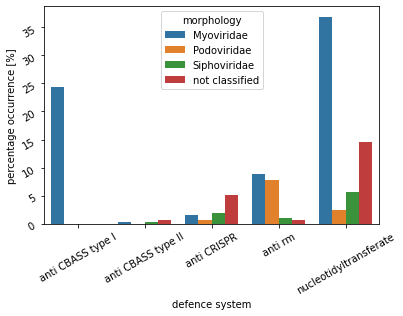

In [565]:
filt_all_hits.loc[:, 'parent defence system'].unique()
a = filt_all_hits.groupby(['ID', 'parent defence system'], as_index = False).size().groupby('ID', as_index = False).size().sort_values('size', ascending = False).rename({'size': 'num antigenes'}, axis = 1)
a.groupby('num antigenes', as_index = False).size()#.loc[:, 'size'].sum()
a = pd.merge(filt_all_hits.groupby(['parent defence system', 'new database ID'], as_index = False).size()[['parent defence system', 'new database ID']], all_IDs_df[['ID', 'full ID']], left_on='new database ID', right_on='ID').drop('new database ID', axis = 1)
a = pd.merge(a.rename({'full ID': 'full ID'},axis = 1), gravity_morphology_df[['full ID', 'morphology']])
c = a.groupby(['parent defence system', 'morphology'], as_index = False).size()
to_merge = pd.merge(all_IDs_df, gravity_morphology_df).groupby('morphology', as_index=False).size()
c = pd.merge(c, to_merge, left_on = 'morphology', right_on = 'morphology')
c.loc[:, 'percentage'] = c.loc[:, 'size_x']/c.loc[:, 'size_y']*100
# c = c[['parent defence system', 'morphology', 'percentage']]
# c
hue_order = ['Myoviridae', 'Podoviridae', 'Siphoviridae', 'not classified']
sns.barplot(data = c[c.loc[:, 'parent defence system'] != 'stealth'], hue = 'morphology', y = 'percentage', x = 'parent defence system', hue_order = hue_order)
ax = plt.gca()
ax.tick_params(rotation=30)
ax.set_xlabel('defence system')
ax.set_ylabel('percentage occurrence [%]')
plt.savefig(r'C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\figures\final_figures' + '/' + 'frequency of anti defence genes per morphology.png', bbox_inches = 'tight', dpi = 500)
plt.show()

In [566]:
c

,parent defence system,morphology,size_x,size_y,percentage
0,anti CBASS type I,Myoviridae,77,317,24.290221
1,anti CBASS type II,Myoviridae,1,317,0.315457
2,anti CRISPR,Myoviridae,5,317,1.577287
3,anti rm,Myoviridae,28,317,8.832808
4,nucleotidyltransferate,Myoviridae,117,317,36.908517
5,stealth,Myoviridae,12,317,3.785489
6,anti CBASS type II,Siphoviridae,2,724,0.276243
7,anti CRISPR,Siphoviridae,14,724,1.933702
8,anti rm,Siphoviridae,8,724,1.104972
9,nucleotidyltransferate,Siphoviridae,41,724,5.662983


In [408]:
a.groupby('parent defence system', as_index = False).size()

,parent defence system,size
0,anti CBASS type I,77
1,anti CBASS type II,4
2,anti CRISPR,28
3,anti rm,50
4,nucleotidyltransferate,185
5,stealth,23


In [417]:
gravity_morphology_df

,full ID name,morphology,color code
0,AB008550_Myoviridae_Peduovirus_Pseudomonas_pha...,Myoviridae,74a9cf
1,AB045978_Siphoviridae_Triavirus_Staphylococcus...,Siphoviridae,de2d26
2,AB063393_Sphaerolipoviridae_Gammasphaerolipovi...,not classified,969696
3,AB231700_Myoviridae__Microcystis_phage_Ma_LMM01,Myoviridae,74a9cf
4,AB243556_Siphoviridae_Biseptimavirus_Staphyloc...,Siphoviridae,de2d26
...,...,...,...
1364,X07234_Fuselloviridae_Alphafusellovirus_sulfol...,not classified,969696
1365,X96987_Podoviridae_Salasvirus_Bacillus_phage_GA1,Podoviridae,fec44f
1366,X99260_Podoviridae_Salasvirus_Bacillus_phage_B103,Podoviridae,fec44f
1367,Z18946_Siphoviridae_Fromanvirus_Mycobacterium_...,Siphoviridae,de2d26


In [434]:
pd.merge(a, gravity_morphology_df.rename({'full ID name': 'full ID'},axis = 1)[['full ID', 'morphology']])

,parent defence system,ID,full ID,morphology
0,anti CBASS type I,AF158101,AF158101_Myoviridae_Tequatrovirus_Escherichia_...,Myoviridae
1,anti rm,AF158101,AF158101_Myoviridae_Tequatrovirus_Escherichia_...,Myoviridae
2,nucleotidyltransferate,AF158101,AF158101_Myoviridae_Tequatrovirus_Escherichia_...,Myoviridae
3,anti CBASS type I,AP011113,AP011113_Myoviridae_Tequatrovirus_Escherichia_...,Myoviridae
4,nucleotidyltransferate,AP011113,AP011113_Myoviridae_Tequatrovirus_Escherichia_...,Myoviridae
...,...,...,...,...
362,stealth,MF490241,MF490241_Myoviridae_Pbunavirus_Pseudomonas_pha...,Myoviridae
363,stealth,Pa10,Query0004_FBPA10,not classified
364,stealth,Pa12,Query0006_FBPA12,not classified
365,stealth,Pa21,Query0002_FBPA21,not classified


In [140]:
b.groupby(['parent defence system'], as_index = False).size().rename({'size': 'total number'}, axis = 1)

,parent defence system,total number
0,anti CBASS type I,77
1,anti CBASS type II,4
2,anti CRISPR,28
3,anti rm,50
4,nucleotidyltransferate,185
5,stealth,23


### See if defence systems are virulent type sepcific

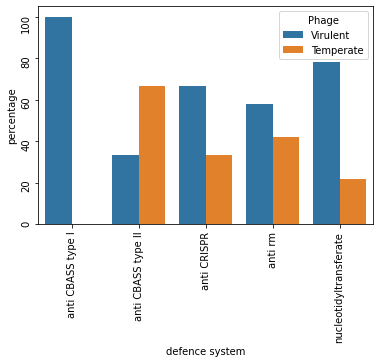

In [546]:
b = pd.merge(a, virulence_df[['Phage', 'full ID']])[['parent defence system', 'Phage']]
c = pd.merge(b.groupby(['parent defence system', 'Phage'], as_index = False).size(), b.groupby(['parent defence system'], as_index = False).size().rename({'size': 'total number'}, axis = 1))
c.loc[:, 'percentage'] = c.loc[:, 'size']/c.loc[:, 'total number']*100
c = c[['parent defence system', 'Phage', 'percentage']]
sns.barplot(data = c[c.loc[:, 'parent defence system'] != 'stealth'], hue = 'Phage', y = 'percentage', x = 'parent defence system')
ax = plt.gca()
ax.tick_params(rotation=90)
ax.set_xlabel('defence system')
#plt.savefig(r'C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\figures\supplementary' + '/' + 'distribution of occurence of anti_defence_systems', bbox_inches = 'tight')
plt.show()

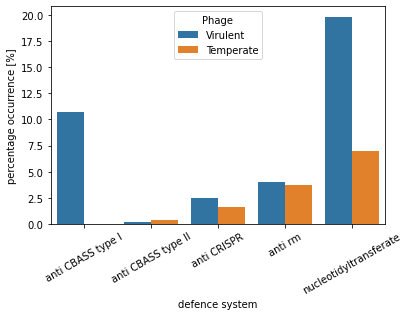

In [564]:
statistics_df = pd.merge(b.groupby(['parent defence system', 'Phage'], as_index = False).size(), virulence_df.groupby(['Phage'],as_index = False).size().rename({'size': 'tot number'}, axis = 1))
statistics_df.loc[:, 'relative frequency [%]'] = statistics_df.loc[:, 'size']/statistics_df.loc[:, 'tot number']*100
sns.barplot(data =statistics_df[statistics_df.loc[:, 'parent defence system'] != 'stealth'], hue = 'Phage', y = 'relative frequency [%]', x = 'parent defence system')
ax = plt.gca()
ax.tick_params(rotation=30)
ax.tick_params('y', rotation=0)
ax.set_xlabel('defence system')
ax.set_ylabel('percentage occurrence [%]')

plt.savefig(r'C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\figures\final_figures' + '/' + 'frequency of anti defence gene per cycle type', bbox_inches = 'tight', dpi = 500)
# plt.show()

### make a tree that shows how large each genome is, and see if there is a correlation between genome size and number of anti-defence systems

In [211]:
genome_length_ID = pd.merge(genome_length_df, all_IDs_df)[['full ID', 'genome length']].reset_index(drop = True)
with open('genome length strip.txt', 'w') as f: 
    f.write('')
    
for ii in range(genome_length_ID.shape[0]): 
    genome_length = genome_length_ID.loc[ii, 'genome length']
    full_name = genome_length_ID.loc[ii, 'full ID']
    with open('genome length strip.txt', 'a') as f: 
        f.write(full_name + '\t' + str(genome_length/1000) + '\n')
# with open('genome length strip.txt', 'a') as f: 
#     f.write('')

In [386]:
genome_length_vs_num_defence_systems = pd.merge(a, genome_length_df)[['parent defence system', 'genome length', 'ID', 'full ID']]
genome_length_vs_num_defence_systems = pd.merge(genome_length_vs_num_defence_systems, genome_length_vs_num_defence_systems.groupby('ID', as_index = False).size())
genome_length_df = pd.merge(genome_length_df, all_IDs_df)[['genome length', 'full ID', 'ID']]
appending_df = genome_length_df[~genome_length_df.loc[:, 'ID'].isin(list(a.loc[:, 'full ID']))]
genome_length_vs_num_defence_systems =  pd.concat([genome_length_vs_num_defence_systems, appending_df])
genome_length_vs_num_defence_systems.loc[:, 'genome length'] = genome_length_vs_num_defence_systems.loc[:, 'genome length']/1000
genome_length_vs_num_defence_systems.loc[:, 'size'] = genome_length_vs_num_defence_systems.loc[:, 'size'].replace(np.NaN, 0)
genome_length_vs_num_defence_systems = pd.merge(genome_length_vs_num_defence_systems, virulence_df[['ID', "Phage"]])
genome_length_vs_num_defence_systems = pd.merge(genome_length_vs_num_defence_systems.rename({'full ID': 'full ID name'}, axis = 1), gravity_morphology_df[['full ID name', 'morphology']])

genome_length_vs_num_defence_systems = genome_length_vs_num_defence_systems.reset_index(drop = True).fillna(0)

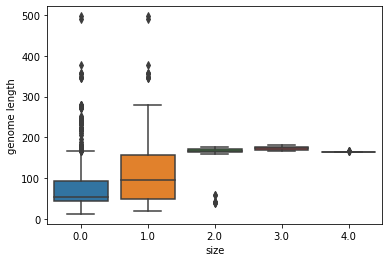

In [389]:
sns.boxplot(data = genome_length_vs_num_defence_systems[['size', 'genome length', 'morphology']], x = 'size', y = 'genome length')
plt.show()

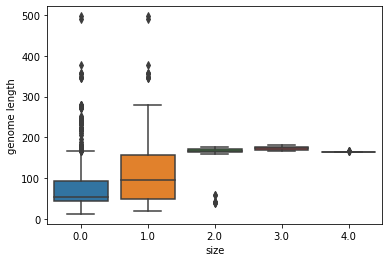

In [392]:
sns.boxplot(data = genome_length_vs_num_defence_systems[['size', 'genome length', 'morphology']], x = 'size', y = 'genome length')
plt.show()

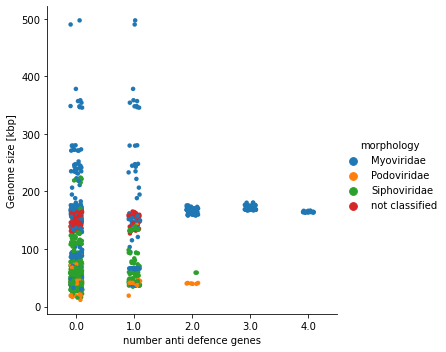

In [563]:
sns.catplot(data = genome_length_vs_num_defence_systems[['size', 'genome length', 'morphology']], x = 'size', y = 'genome length',hue = 'morphology', s = 4.5, hue_order=hue_order)
ax = plt.gca()
ax.set_xlabel('number anti defence genes')
ax.set_ylabel('Genome size [kbp]')
plt.savefig(r'C:\Users\Halewijn\OneDrive\Documenten\third year\BEP\thesis\figures\final_figures' + '/' + 'genome size vs number anti defence genes', bbox_inches = 'tight', dpi = 500)
plt.show()

#### some statistics

In [312]:
#defence system/number of virulent phages
defence_systems_in_temperate =  b.groupby('Phage').size().Temperate
defence_systems_in_virulent =  b.groupby('Phage').size().Virulent
num_temperate =  (virulence_df.loc[:, 'Phage'] == 'Temperate').sum()
num_virulent =  (virulence_df.loc[:, 'Phage'] == 'Virulent').sum()
question_1 = defence_systems_in_t|emperate/num_temperate
question_2 = defence_systems_in_virulent/num_virulent
question_1

KeyError: 'Phage'

In [100]:
b = pd.merge(a.groupby('ID', as_index = False).size(), virulence_df)
(b.loc[:, 'Phage'] == 'Virulent').sum()/b.shape[0]*100

72.15686274509804

In [110]:
p_temperate = (virulence_df.loc[:, 'Phage'] == 'Temperate').sum()/virulence_df.shape[0]*100
p_virulent = (virulence_df.loc[:, 'Phage'] == 'Virulent').sum()/virulence_df.shape[0]*100
p_virulent + p_temperate

100.0